In [17]:
import random
import numpy.random as rnd
# import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
# from jupyter_server import serverapp as app; 
# import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
    
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint

from jupyter_server import serverapp as app; 
import ipykernel, requests;

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 25
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40

In [18]:
1-np.exp(-1)

0.6321205588285577

In [19]:
nb_name = os.path.basename(globals()['__vsc_ipynb_file__'])
nb_name= nb_name[:nb_name.find('.ipynb')]


obsidian_vault_folder = os.path.expanduser("~")+'/Dropbox/Work_main/Obsidian/Project_tree/Project_Tree/'
figures_folder = obsidian_vault_folder + '/figures/'+nb_name+'/'
os.makedirs(figures_folder,exist_ok=True)

#set the global figures folder to be the 

In [20]:
#read all the files in the folder "data/parameter_runs/frequency_distribution/" into a list of dataframes using the pandas from_feather function
data_folder = os.path.relpath('../data/parameter_runs/frequency_distribution/')
data_files = os.listdir(data_folder)
data_files = [data_folder+'/'+f for f in data_files]
dataframes = [pd.read_feather(f) for f in data_files]


In [54]:
sys.path.append(os.path.relpath('..'))

#import funcs as funcs
import analysis.mathematical_functions.funcs as funcs

from plotting.plot_frequencies import *




In [47]:
parallel_subfolder= data_folder[funcs.find_end_substring(data_folder,'data/'):]
results_folder = os.path.relpath('../results/'+parallel_subfolder)
os.makedirs(results_folder,exist_ok=True)

In [48]:
parallel_subfolder

'parameter_runs/frequency_distribution'

In [49]:
#get all the unique values of 'infection_rate' and mutation_rate' from the dataframes into two numpy arrays 'beta_s' and 'mu_s'
beta_s = np.unique(np.concatenate([df['infection_rate'].values for df in dataframes]))
mu_s = np.unique(np.concatenate([df['mutation_rate'].values for df in dataframes]))
N = 10000
xi=20
p_alpha= .1
xi_d = -1/np.log(1-p_alpha)

In [50]:

#wrap this cell under a function that takes into the dataframes and returns the conditioned_df
def get_conditioned_df(dataframes,beta_s,mu_s,N, xi,p_alpha):
    xi_d = -1/np.log(1-p_alpha)
    conditioned_dict = {}
    j=0
    tot_sims = 0 
    for i_x, x in enumerate(product(beta_s,mu_s)):
        beta, mu = x 
        count_sims= 0
        for dd in dataframes:
                max_num_pairs = len(dd.columns[2:])//2

                d_columns= dd.columns[2:2+max_num_pairs]
                chi_columns= dd.columns[2+max_num_pairs:]
                chi_d = dd[ np.logical_and(dd['infection_rate']==beta, dd['mutation_rate']==mu)][chi_columns].values[0]
                d_chi = dd[ np.logical_and(dd['infection_rate']==beta, dd['mutation_rate']==mu)][d_columns].values[0]
                for d,chi in zip(d_chi,chi_d):
                    if ~np.isnan(d):        
                        if d==0:
                            count_sims+=1
                        if chi>0:
                            conditioned_dict[j]=[beta,mu, N, xi, p_alpha, count_sims, d, chi]
                            j+=1
    conditioned_df = pd.DataFrame.from_dict(conditioned_dict, orient='index', columns=['beta','mu', 'N', 'xi', 'p_alpha','n_sim', 'd', 'chi'])
    return conditioned_df

if not os.path.exists(results_folder+'/conditioned_df.feather'):
    conditioned_df= get_conditioned_df(dataframes,beta_s,mu_s,N, xi,p_alpha)
    conditioned_df.to_feather(results_folder+'/conditioned_df.feather')
else:
    conditioned_df = pd.read_feather(results_folder+'/conditioned_df.feather')

    

In [51]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
counts_df = get_counts_df(conditioned_df, 6250)
#get a column of counts df with the total counts for each beta,mu,N, xi, p_alpha




In [56]:
figures_folder

'/Users/dtrimcev/Dropbox/Work_main/Obsidian/Project_tree/Project_Tree//figures/read_freq_feather_data/'

<AxesSubplot:>

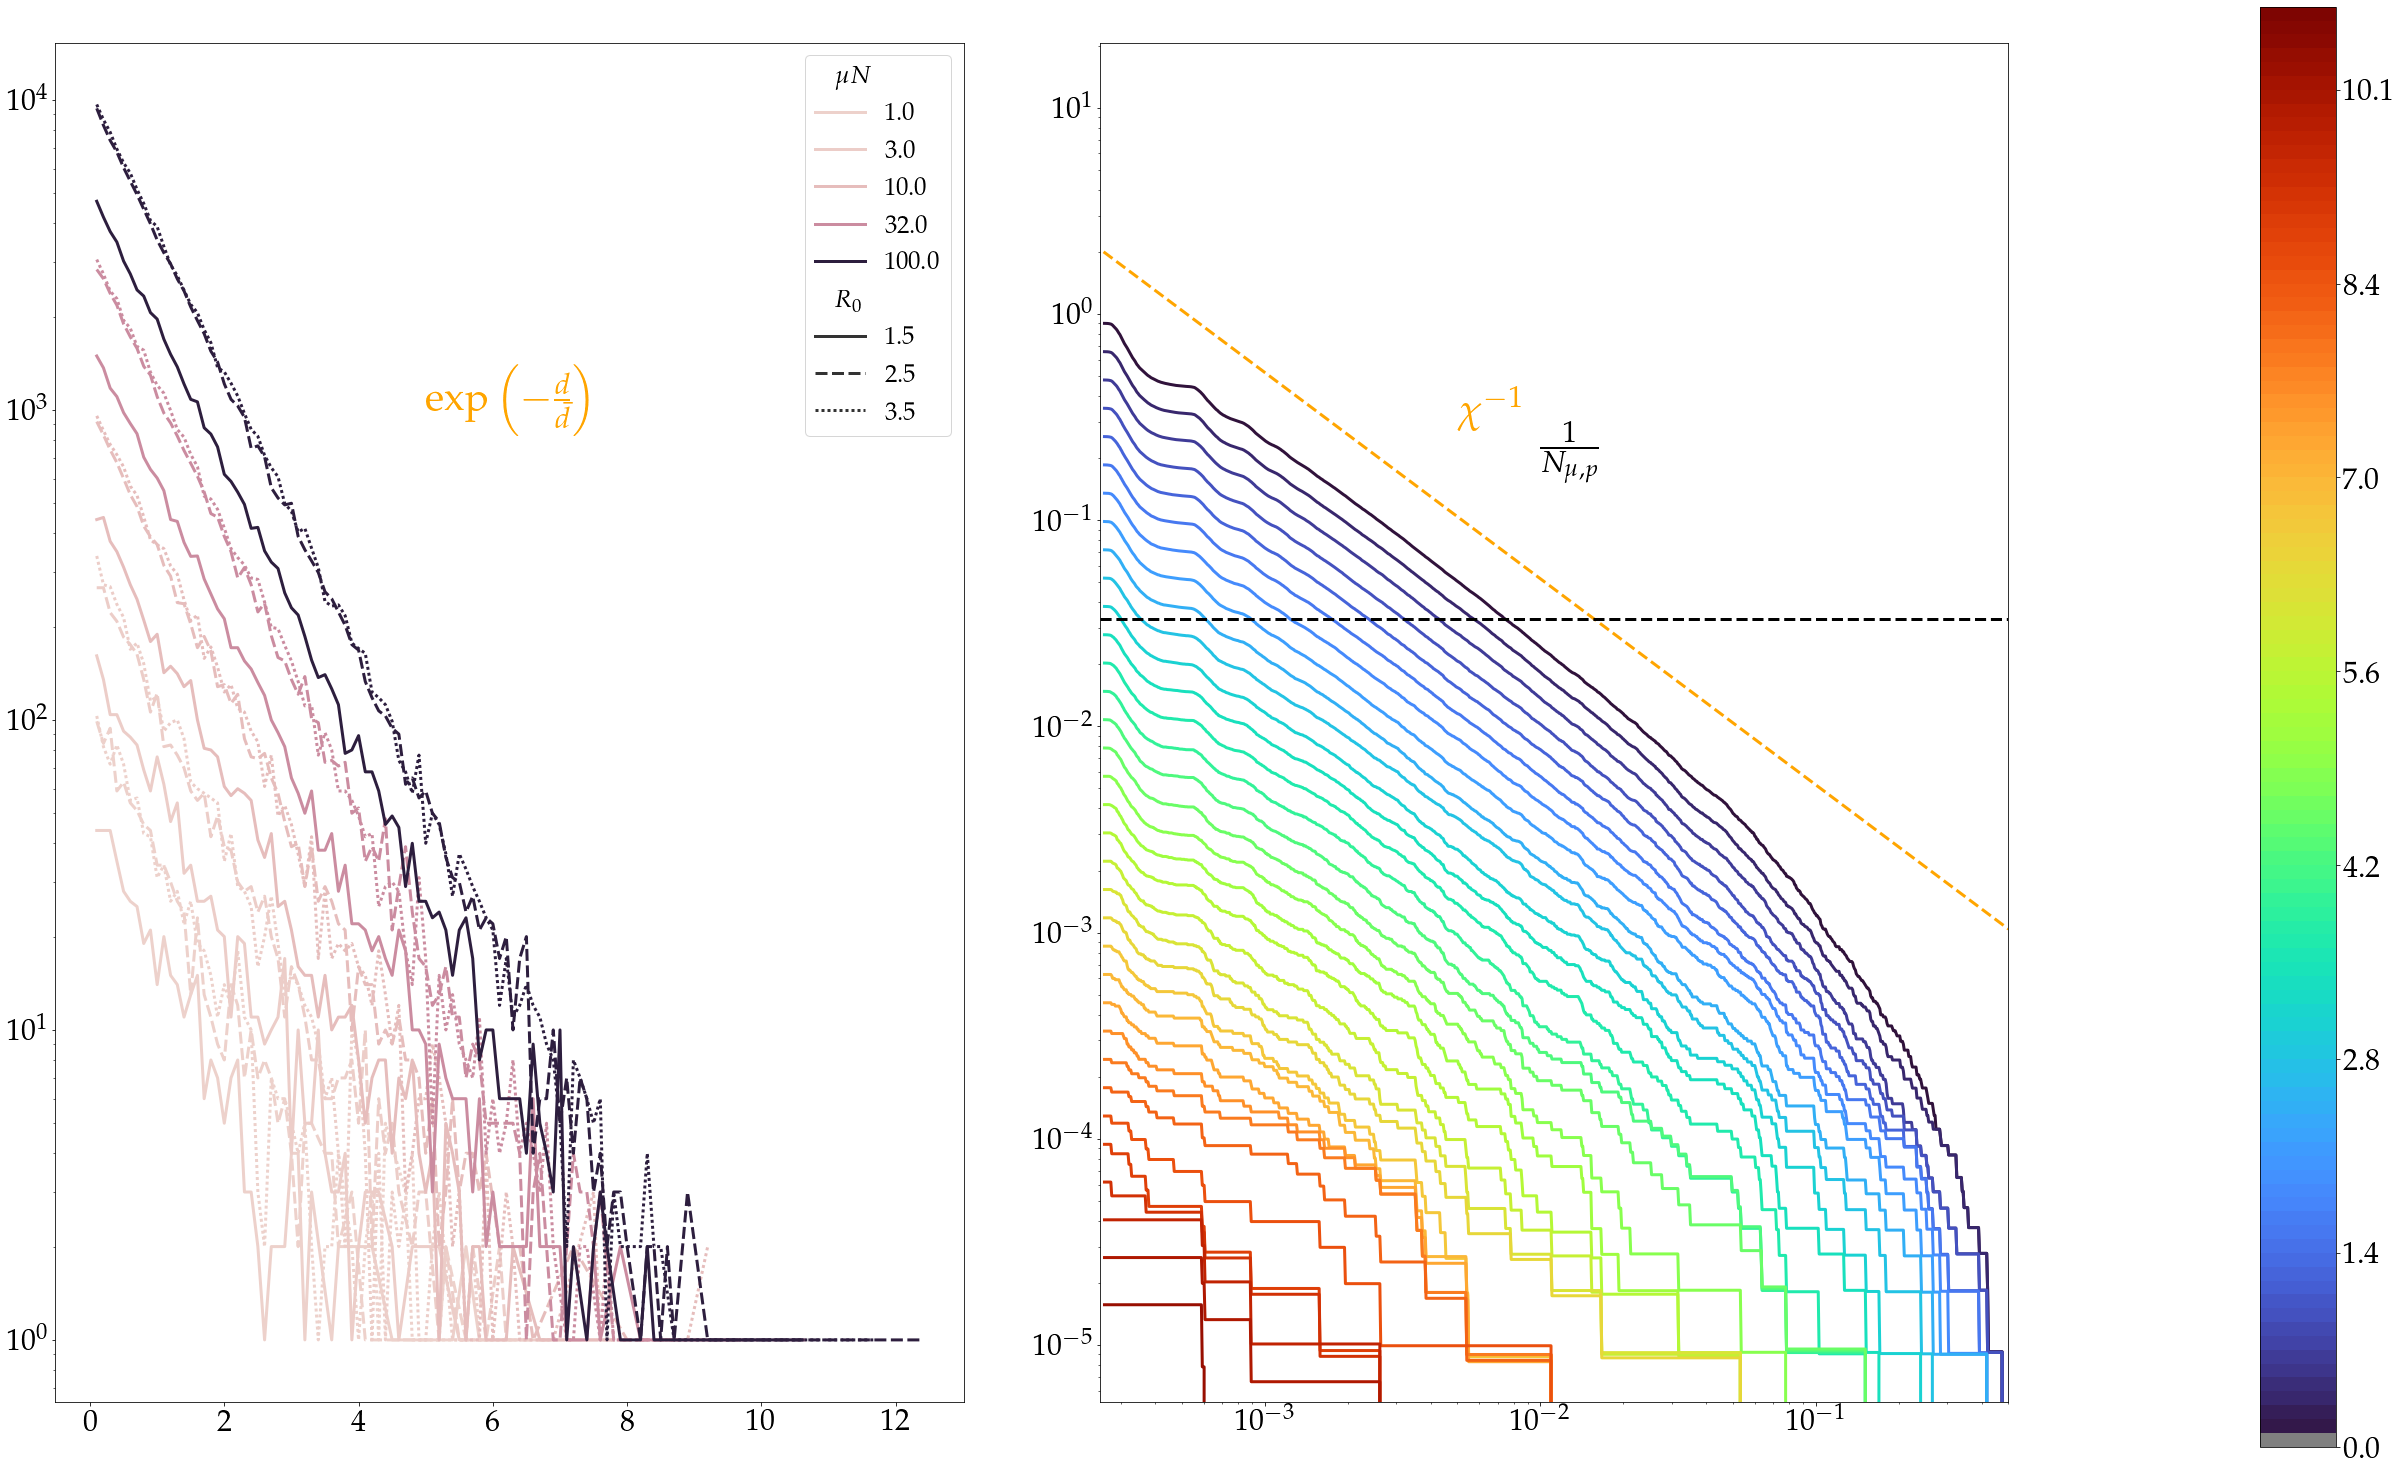

In [58]:
%autoreload
beta, mu = beta_s[-1], mu_s[-1]

#plot the two into a figure with two axes 
fig,ax = plt.subplots(1,2,figsize=(35,25),sharey=False)
plt.subplots_adjust(wspace=.15)

# ax[0].plot(np.arange(1,100)*p_alpha,2e4*np.exp(-np.arange(1,100)/xi_d), color='orange',linestyle='--')
#annotate \exp{-d/dbar} at (6,5000)
ax[0].annotate(r'$\exp\left(-\frac{d}{\bar{d}}\right)$',xy=(5,1000) ,fontsize=40, color='orange')
plot_counts_by_antigenic_effect(conditioned_df,ax[0],6250)
plot_double_ecdf_by_antigenic_effect(conditioned_df,ax[1],fig,beta,mu,N,p_alpha,N_sim=6250)
#set same ylim on both axes
# ax[0].set_ylim(ax[1].get_ylim())
# plt.savefig(figures_folder+'count_recap.jpg',bbox_inches='tight')
    



In [64]:
xi_d = -1/np.log(1-p_alpha)

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  # This is added back by InteractiveShellApp.init_path()


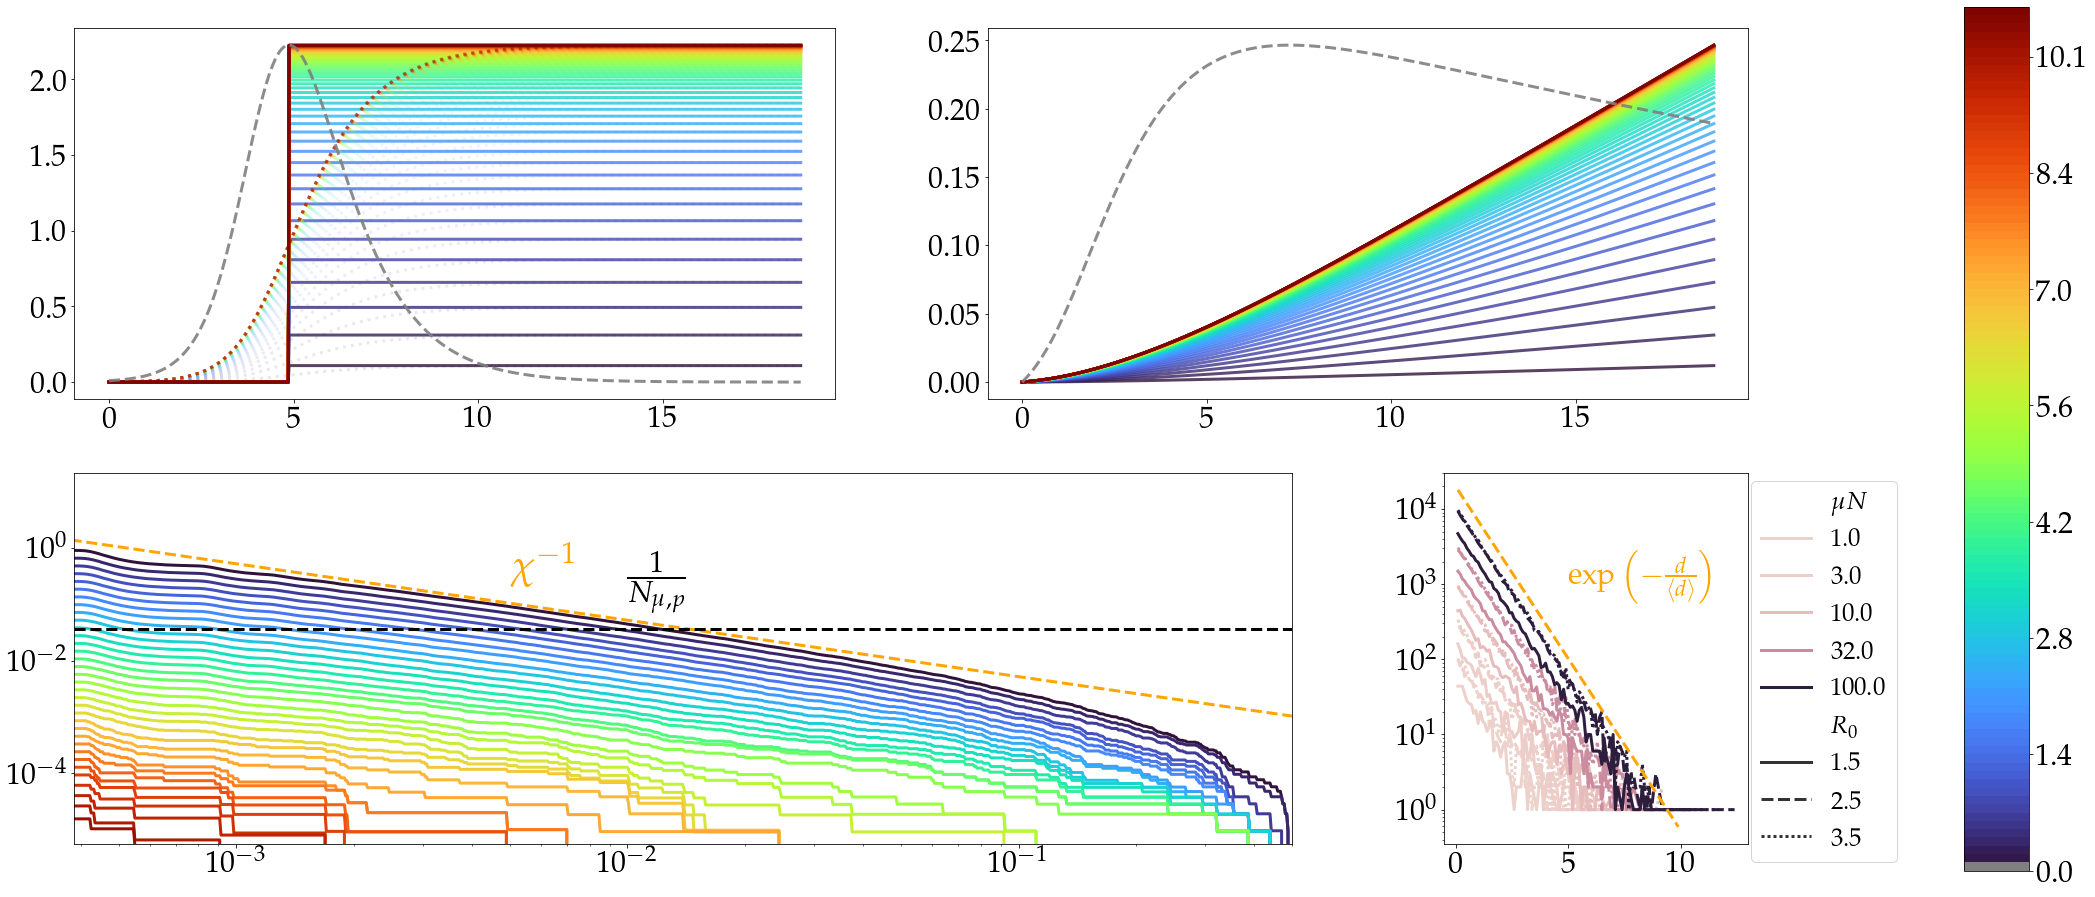

In [65]:
%autoreload
mosaic = """
AABB
CCCD
"""

beta = 2.5
fig = plt.figure(layout="constrained", figsize=(30,15))
ax_dict = fig.subplot_mosaic(mosaic)

plt.subplots_adjust(wspace=.5)

plot_counts_by_antigenic_effect(conditioned_df,ax_dict['D'],6250)

ax_dict['D'].plot(np.arange(1,100)*p_alpha,2e4*np.exp(-np.arange(1,100)/xi_d), color='orange',linestyle='--')
#annotate \exp{-d/dbar} at (6,5000)
ax_dict['D'].annotate(r'$\exp\left(-\frac{d}{\langle d \rangle}\right)$',xy=(5,1000) ,fontsize=30, color='orange')
ax_dict['D'].legend(loc= (1.01,-.05))

plot_double_ecdf_by_antigenic_effect(conditioned_df,ax_dict['C'],fig,beta,mu,N,p_alpha,N_sim=6250)

R0 = beta
kappa=0

ds = np.arange(1, conditioned_df['d'].max())
# t_peak = funcs.t_peak(beta,N)

T_kappa0 = funcs.T_ext_deterministic(R0,0,N)
ts_kappa0 = np.linspace(0,T_kappa0,1000)
x_kappa0,y_kappa0,z_kappa0= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_kappa0, args=(R0,kappa)).T
t_peak = ts_kappa0[np.argmax(y_kappa0)]
z_inf = 1-funcs.x_inf(R0,kappa)

kappa = 100
T_kappa100 = funcs.T_ext_deterministic(R0,kappa,N)
ts_kappa100 = np.linspace(0,T_kappa0,1000)
x_kappa100,y_kappa100,z_kappa100= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_kappa100, args=(R0,kappa)).T


colors_d = funcs.color_dict(ds,plt.cm.turbo)
for d in ds[::2]:
    stepwise_selection = R0*z_inf*(1-np.exp(-d/xi))*(ts_kappa0>=t_peak)
    ax_dict['A'].plot(ts_kappa0, stepwise_selection, color= colors_d[d], alpha=.8)
    ax_dict['A'].plot(ts_kappa0, R0*z_kappa0*(1-np.exp(-d/xi)), color= colors_d[d], alpha=.1,linestyle=':')

    ax_dict['B'].plot(ts_kappa100, R0/(1+kappa* y_kappa100)* z_kappa100*(1-np.exp(-d/xi)), color= colors_d[d], alpha=.8)

taxA = ax_dict['A'].twinx()
taxA.plot(ts_kappa0, y_kappa0, color= 'grey', alpha=.9,linestyle='--')
# taxA.set_yscale('log')
taxA.axis('off')

taxB = ax_dict['B'].twinx()
taxB.plot(ts_kappa100, y_kappa100, color= 'grey', alpha=.9,linestyle='--')

taxB.axis('off')

plt.savefig(results_folder+'/fig3.pdf',bbox_inches='tight')



In [67]:
xi

20

In [ ]:
figures_folder

'/Users/dtrimcev/Dropbox/Work_main/Obsidian/Project_tree/Project_Tree//figures/read_freq_feather_data/'

In [ ]:
sns.ecdfplot(data=conditioned_df[conditioned_df['beta']==beta][conditioned_df['mu']==mu]['chi'],ax=ax[1],color='black',linewidth=3, stat='proportion',label=r'$\beta={0:.2f}, \mu={1:.2f}$'.format(beta,mu))

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<AxesSubplot:title={'center':'Frequency counts, $R_0=3.5\\; \\mu N= 100$'}, xlabel='$x$, frequency', ylabel='$N_\\mathrm{sim} \\,N_\\mathrm{m}\\, P_d(X>x)$, counts'>

(0.00026007802340702216, 0.00026007802340702216)

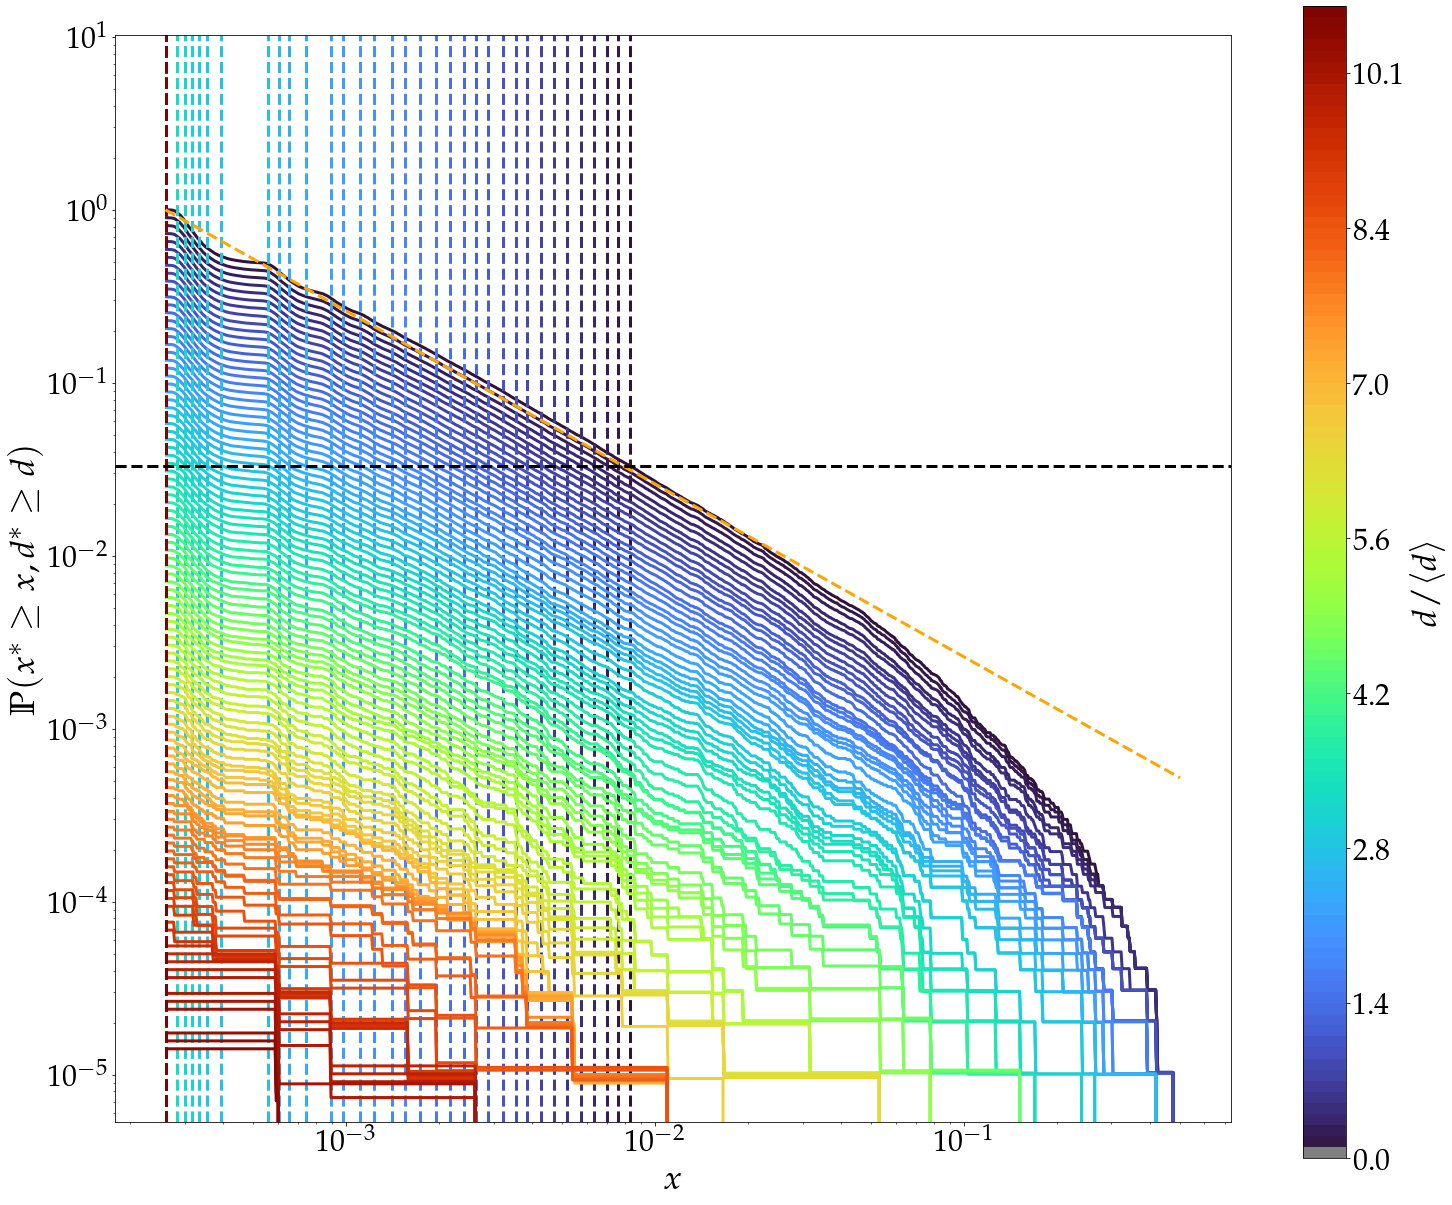

In [ ]:
N_sim = 6250
beta, mu = beta_s[-1], mu_s[-1]
ds= np.array(list(set(conditioned_df.query('d>0')['d'])))
bins = np.logspace(np.log10(conditioned_df.min()['chi']), np.log10(.5),1000).flatten()

powlaw = lambda x,p1,p2: p1*np.power(x,p2)
linlaw = lambda x,p1,p2: p1*x+p2

qstring=f"beta == {beta} & mu=={mu} & d>0"
conditioned_df.query(qstring)
colors_d = funcs.color_dict(ds,plt.cm.turbo)
fig,ax= plt.subplots(1,1,figsize=(20,20))

x_intersections = []
for d in ds:
    d_df = conditioned_df.query(qstring).query(f'd>={d}')
    h_d,b_d = np.histogram(d_df['chi'],bins=bins,density=True)
    dx = np.diff(b_d)

    f_d = np.cumsum(dx*h_d)
    plt.plot(b_d[1:],(1-p_alpha)**(d-1)*(1-f_d),label=f'd={d}',color=colors_d[d])
    #find intersection between (1-p_alpha)**(d-1)*(1-f_d) and 1/Nmut_single_epidemic and append to x_intersections
    x_intersections.append(b_d[1:][np.argmin(np.abs((1-p_alpha)**(d-1)*(1-f_d)-1/(funcs.Nmut_single_epidemic(beta,mu,N))))])
    plt.axvline(x_intersections[-1],color=colors_d[d],linestyle='--')
    
ax.set_xscale('log')
ax.plot(bins,bins[0]/bins,color='orange',linestyle='--')
ax.set_yscale('log')
ax.axhline(1/(funcs.Nmut_single_epidemic(beta,mu,N)),color='black',linestyle='--')
ax.set_ylim(bottom=1/(funcs.Nmut_single_epidemic(beta,mu,N)*N_sim))
ax.set_ylabel(r'$\mathbb{P}(x^* \geq x, d^*\geq d)$')
ax.set_xlabel(r'$x$')

ds= np.array(list(set(conditioned_df['d'])))
cmap = plt.cm.turbo  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = ds*p_alpha
norm = mpl.colors.BoundaryNorm(ds*p_alpha, cmap.N)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])

# ax.axvline(2/11)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax2, orientation='vertical', label=r'$d/\langle d \rangle$', ticks=bounds[::14], boundaries=bounds[::14],format=FuncFormatter(fmt))#, format='%1f')

# plt.savefig(figures_folder+'double_cumulative.jpg',bbox_inches='tight')

In [ ]:
colors_mu = funcs.color_dict(mu_s,plt.cm.turbo)

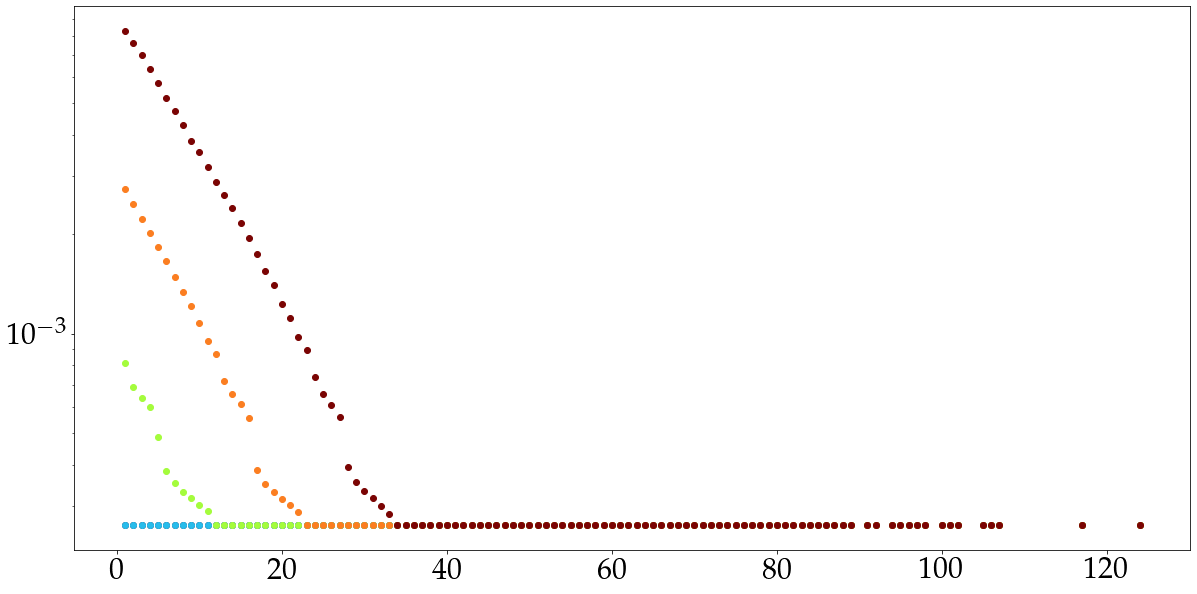

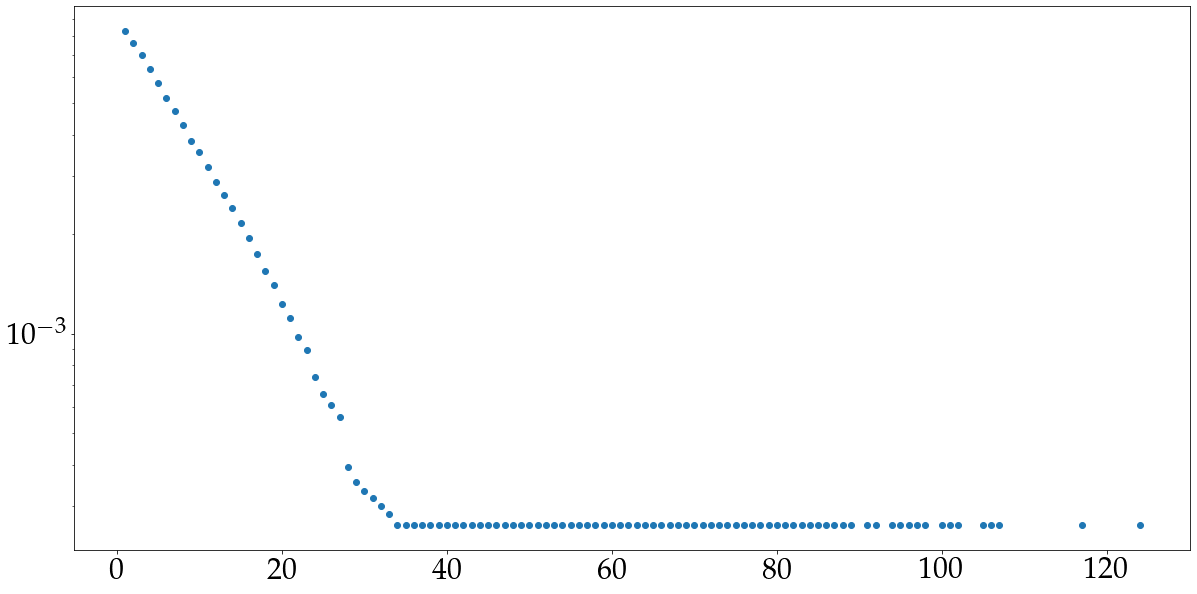

In [ ]:
xbar = bins[np.argmin(np.abs(double_cumulative-1/(funcs.Nmut_single_epidemic(beta,mu,N))),axis=1)]
xbar = xbar.flatten()
ds = ds.flatten()
fig,ax =plt.subplots()

ax.plot(ds,xbar,'o')
ax.set_yscale('log')

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


(5.3140123002242e-06, 10.19093297058212)

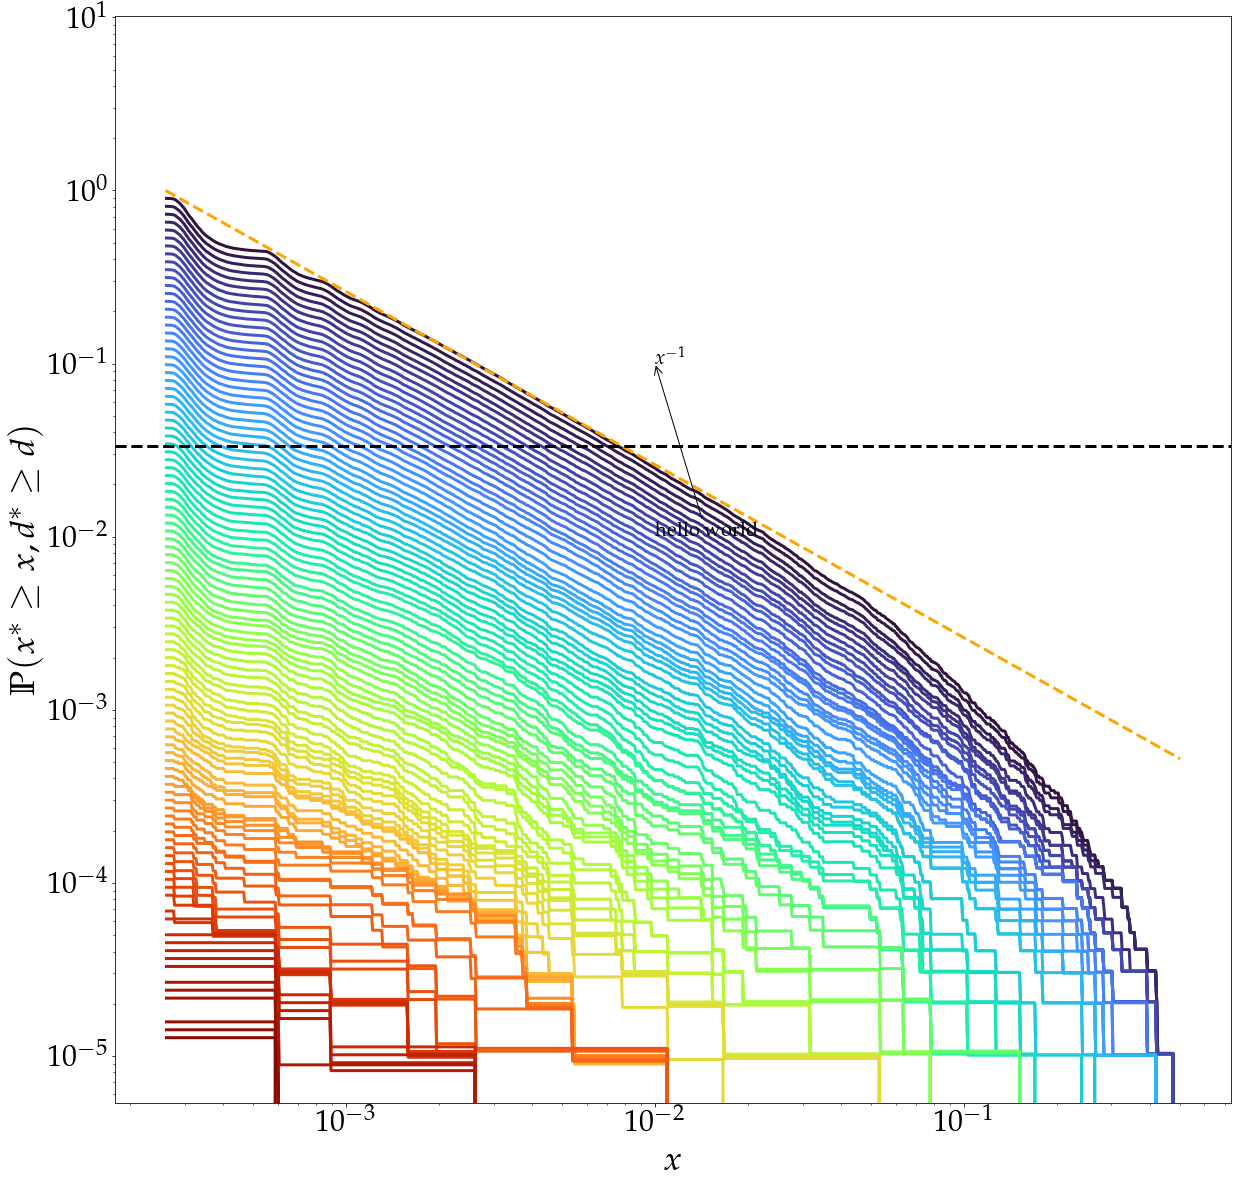

In [ ]:
beta, mu = beta_s[-1], mu_s[-1]
ds= np.array(list(set(conditioned_df.query('d>0')['d'])))
bins = np.logspace(np.log10(conditioned_df.min()['chi']), np.log10(.5),1000).flatten()


qstring=f"beta == {beta} & mu=={mu} & d>0"
conditioned_df.query(qstring)
colors_d = funcs.color_dict(ds,plt.cm.turbo)
fig,ax= plt.subplots(1,1,figsize=(20,20))
for d in ds:
    d_df = conditioned_df.query(qstring).query(f'd>{d}')
    h_d,b_d = np.histogram(d_df['chi'],bins=bins,density=True)
    dx = np.diff(b_d)
    f_d = np.cumsum(dx*h_d)
    plt.plot(b_d[1:],(1-p_alpha)**d *(1-f_d),label=f'd={d}',color=colors_d[d])

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\mathbb{P}(x^* \geq x, d^*\geq d)$')
#annotate x^-1 in latex at (1e-2,1e-1)
ax.annotate(r'$x^{-1}$', xy=(1e-2, 1e-1), xycoords='data',xytext=(1e-2, 1e-1), textcoords='data',fontsize=20)
ax.set_xscale('log')
ax.plot(bins,bins[0]/bins,color='orange',linestyle='--')
ax.set_yscale('log')
ax.axhline(1/(funcs.Nmut_single_epidemic(beta,mu,N)),color='black',linestyle='--')
ax.set_ylim(bottom=1/(funcs.Nmut_single_epidemic(beta,mu,N)*N_sim))

In [ ]:
#convert the following into a python function: (N\[Mu]*(1 - p)**dstar*xmin)/(1 - 2*xmin + 2*N\[Mu]*(1 - p)**dstar*xmin)
xmax = lambda d, p_alpha, R0, mu, N, xmin : (N*mu* np.log(R0)/R0*(1-p_alpha)**d*xmin)/(1-2*xmin+2*N*mu* np.log(R0)/R0*(1-p_alpha)**d*xmin) 
# # now write xmax in a Latex string
# xmax_latex = r'$\frac{N \mu (1-p)^d x_{min}}{1-2x_{min}+2N \mu (1-p)^d x_{min}}$'



/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


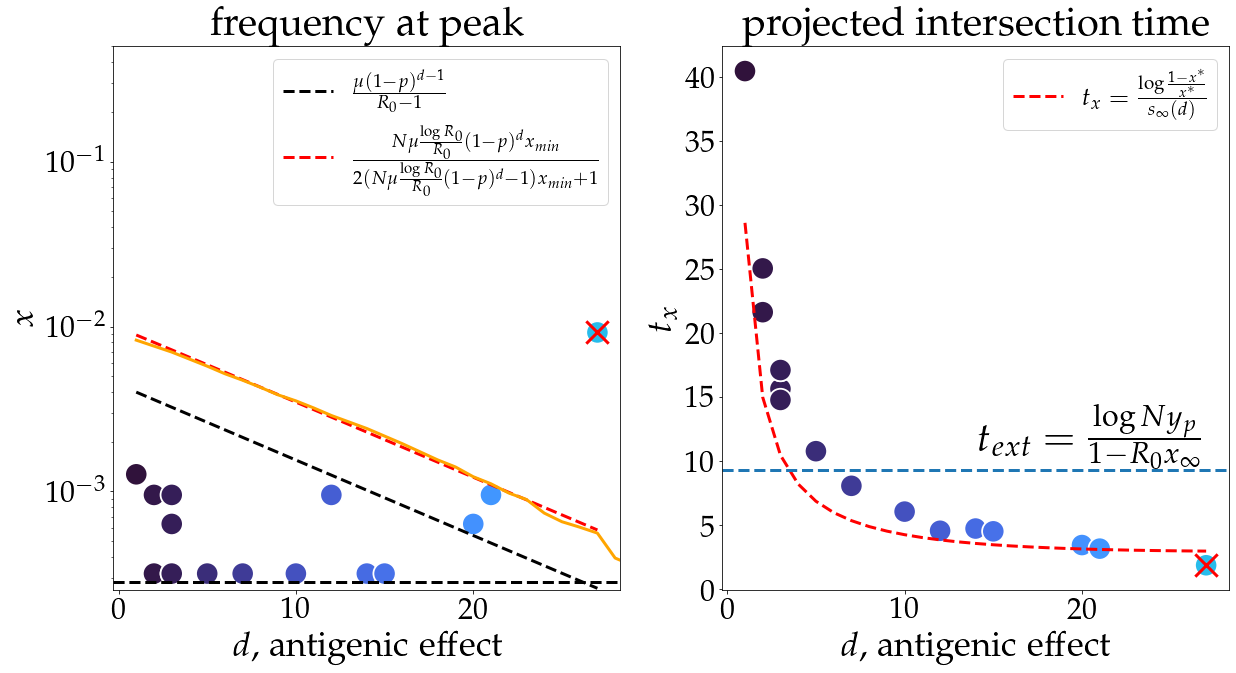

In [ ]:

%autoreload

qstring=f"beta == {beta} & mu=={mu} & d>0"
nsim =rnd.randint(1,N_sim)
singlesim = conditioned_df.query(qstring).query(f'n_sim == {nsim}').drop(columns=['beta','mu','N','xi','p_alpha','n_sim']).sort_values(by='d')

#create a column of singlesim with t_x, defined as log((1-chi)/chi)/funcs.s_d_inf(d,beta,mu,N)
singlesim['t_x'] = np.log((1-singlesim['chi'])/singlesim['chi'])/funcs.s_d_infinity(beta,singlesim['d'],xi,0)


ds_singlesim = np.arange(1,singlesim['d'].max()+1)

ds_bar, xbars = funcs.get_xbar(conditioned_df,beta,mu,p_alpha,N)

Nmut = singlesim.count()

xs_star = np.array([xmax(d, p_alpha, beta, mu, N, funcs.x_min_luria_dellbruck(beta,N)) for d in ds_singlesim])
xs_max = np.array([x_max_of_Nmut(d, Nmut ,beta,N,p_alpha) for d in ds_singlesim])

#get the index of the dataframes where t_x is minimum
idxmin = singlesim['t_x'].idxmin()
#get d,chi, and t_x at the index of minimum t_x
singlesim_min = singlesim.loc[idxmin,['d','chi','t_x']]


fig,ax= plt.subplots(1,2,figsize=(20,10))
sns.scatterplot(singlesim, x='d', y='chi', hue='d', palette=colors_d, legend=False,ax = ax[0], s=500)
ax[0].scatter(singlesim_min['d'],singlesim_min['chi'],color='red',marker='x',s=500)

ax[0].plot(ds_singlesim, mu*(1-p_alpha)**(ds_singlesim-1)/(beta-1),color='black',linestyle='--', label = r'$\frac{\mu (1-p)^{d-1}}{R_0-1}$')
#plot xstar
ax[0].plot(ds_singlesim,xs_star,color='red',linestyle='--', label = r'$\frac{N \mu \frac{\log R_0}{R_0} (1-p)^d x_{min}}{2(N \mu \frac{\log R_0}{R_0}(1-p)^d-1) x_{min}+1}$')

xlim = ax[0].get_xlim()
ax[0].plot(ds,x_intersections,color='orange',)
ax[0].set_xlim(xlim)
ax[0].axhline(funcs.x_min_luria_dellbruck(beta,N),color='black',linestyle='--')
ax[0].set_ylim(bottom=funcs.x_min_luria_dellbruck(beta,N)*.9,top=5e-1)
ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('$x$',)
ax[0].set_xlabel('$d$, antigenic effect',)
ax[0].set_title(f'frequency at peak')
# ax[1].plot(ds_singlesim, mu*(1-p_alpha)**(ds_singlesim-1)/(beta-1),color='black',linestyle='--', label = r'$\frac{\mu (1-p)^{d-1}}{R_0-1}$')
ax[1].plot(ds_singlesim, funcs.tx_func(xs_star,funcs.s_d_infinity(beta,ds_singlesim,xi)),color='red',linestyle='--', label = r'$t_x = \frac{\log \frac{1-x^*}{x^*}}{s_\infty(d)}$')

ax[1].axhline(np.log(N*funcs.y_peak(beta))/(1-beta*funcs.x_inf(beta,0)),linestyle='--')
#annotate t_ext at (10,20)\
xlim1 = ax[1].get_xlim()
ax[1].annotate(r'$t_{ext} = \frac{\log N y_p}{1-R_0 x_\infty}$',xytext=(xlim1[1]/2,11), fontsize=40, xy=(10,np.log(N*funcs.y_peak(beta))/(1-beta*funcs.x_inf(beta,0))))

sns.scatterplot(singlesim, x='d', y='t_x', hue='d', palette=colors_d, legend=False,ax = ax[1], s=500)
ax[1].scatter(singlesim_min['d'],singlesim_min['t_x'],color='red',marker='x',s=500)
# ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('$t_x$',)
ax[1].set_title(f'projected intersection time')
ax[1].set_xlabel('$d$, antigenic effect',)
plt.savefig(figures_folder+f'single_sim_{nsim}_beta_{beta}_mu_{mu}_N_{N}_xi_{xi}_p_alpha_{p_alpha}.png',dpi=300)

In [ ]:
ds= np.array(list(set(conditioned_df.query('d>0')['d'])))
colors_d = funcs.color_dict(ds,plt.cm.turbo)

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


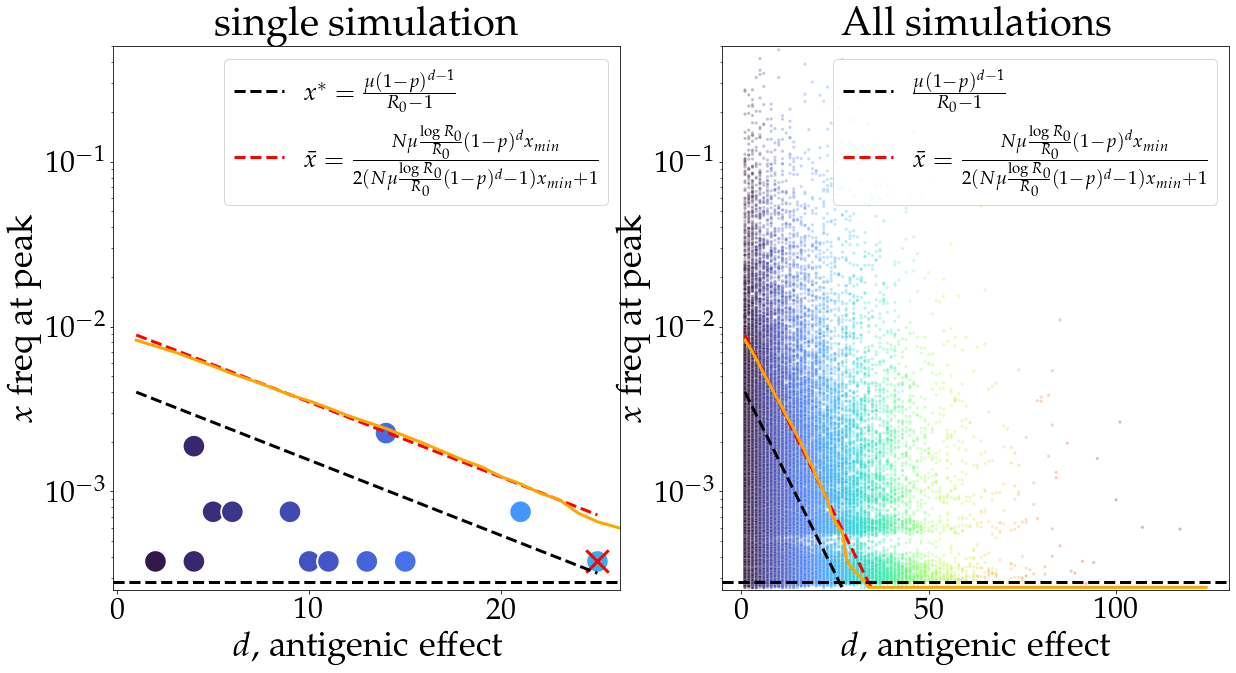

In [ ]:
N_sim = 6250
%autoreload

qstring=f"beta == {beta} & mu=={mu} & d>0"
nsim =rnd.randint(1,N_sim)
singlesim = conditioned_df.query(qstring).query(f'n_sim == {nsim}').drop(columns=['beta','mu','N','xi','p_alpha','n_sim']).sort_values(by='d')

#create a column of singlesim with t_x, defined as log((1-chi)/chi)/funcs.s_d_inf(d,beta,mu,N)
singlesim['t_x'] = np.log((1-singlesim['chi'])/singlesim['chi'])/funcs.s_d_infinity(beta,singlesim['d'],xi,0)


ds_singlesim = np.arange(1,singlesim['d'].max()+1)

ds_bar, xbars = funcs.get_xbar(conditioned_df,beta,mu,p_alpha,N)

Nmut = singlesim.count()

xs_star = np.array([xmax(d, p_alpha, beta, mu, N, funcs.x_min_luria_dellbruck(beta,N)) for d in ds_singlesim])
xs_bar_extended = np.array([xmax(d, p_alpha, beta, mu, N, funcs.x_min_luria_dellbruck(beta,N)) for d in ds])

xs_max = np.array([x_max_of_Nmut(d, Nmut ,beta,N,p_alpha) for d in ds_singlesim])

#get the index of the dataframes where t_x is minimum
idxmin = singlesim['t_x'].idxmin()
#get d,chi, and t_x at the index of minimum t_x
singlesim_min = singlesim.loc[idxmin,['d','chi','t_x']]
ds_bar, x_bar = funcs.get_xbar(conditioned_df,beta,mu,p_alpha,N)

fig,ax= plt.subplots(1,2,figsize=(20,10))
sns.scatterplot(singlesim, x='d', y='chi', hue='d', palette=colors_d, legend=False,ax = ax[0], s=500)
ax[0].scatter(singlesim_min['d'],singlesim_min['chi'],color='red',marker='x',s=500)

ax[0].plot(ds_singlesim, mu*(1-p_alpha)**(ds_singlesim-1)/(beta-1),color='black',linestyle='--', label = r'$x^* = \frac{\mu (1-p)^{d-1}}{R_0-1}$')
#plot xstar
ax[0].plot(ds_singlesim,xs_star,color='red',linestyle='--', label = r'$\bar{x}=\frac{N \mu \frac{\log R_0}{R_0} (1-p)^d x_{min}}{2(N \mu \frac{\log R_0}{R_0}(1-p)^d-1) x_{min}+1}$')

xlim = ax[0].get_xlim()
ax[0].plot(ds_bar,x_bar,color='orange',)
# ax[0].plot(ds,x_intersections,color='orange',)
ax[0].set_xlim(xlim)
ax[0].axhline(funcs.x_min_luria_dellbruck(beta,N),color='black',linestyle='--')
ax[0].set_ylim(bottom=funcs.x_min_luria_dellbruck(beta,N)*.9,top=5e-1)
ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('$x$ freq at peak',)
ax[0].set_xlabel('$d$, antigenic effect',)
ax[0].set_title(f'single simulation')

sns.scatterplot(conditioned_df.query(qstring), x='d', y='chi', hue='d', palette=colors_d, legend=False,ax = ax[1], s=10,alpha=.3)


ax[1].plot(ds, mu*(1-p_alpha)**(ds-1)/(beta-1),color='black',linestyle='--', label = r'$\frac{\mu (1-p)^{d-1}}{R_0-1}$')
#plot xstar
ax[1].plot(ds,xs_bar_extended,color='red',linestyle='--', label = r'$\bar{x} = \frac{N \mu \frac{\log R_0}{R_0} (1-p)^d x_{min}}{2(N \mu \frac{\log R_0}{R_0}(1-p)^d-1) x_{min}+1}$')


xlim = ax[1].get_xlim()
ax[1].plot(ds_bar,x_bar,color='orange',)
ax[1].set_xlim(xlim)
ax[1].axhline(funcs.x_min_luria_dellbruck(beta,N),color='black',linestyle='--')
ax[1].set_ylim(bottom=funcs.x_min_luria_dellbruck(beta,N)*.9,top=5e-1)
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('$x$ freq at peak',)
ax[1].set_xlabel('$d$, antigenic effect',)
ax[1].set_title(f'All simulations')

plt.savefig(figures_folder+f'scatter_recap_beta_{beta}_mu_{mu}_N_{N}_xi_{xi}_p_alpha_{p_alpha}.jpg',dpi=300)

In [ ]:
colors_mu = funcs.color_dict(mu_s,plt.cm.inferno_r)

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


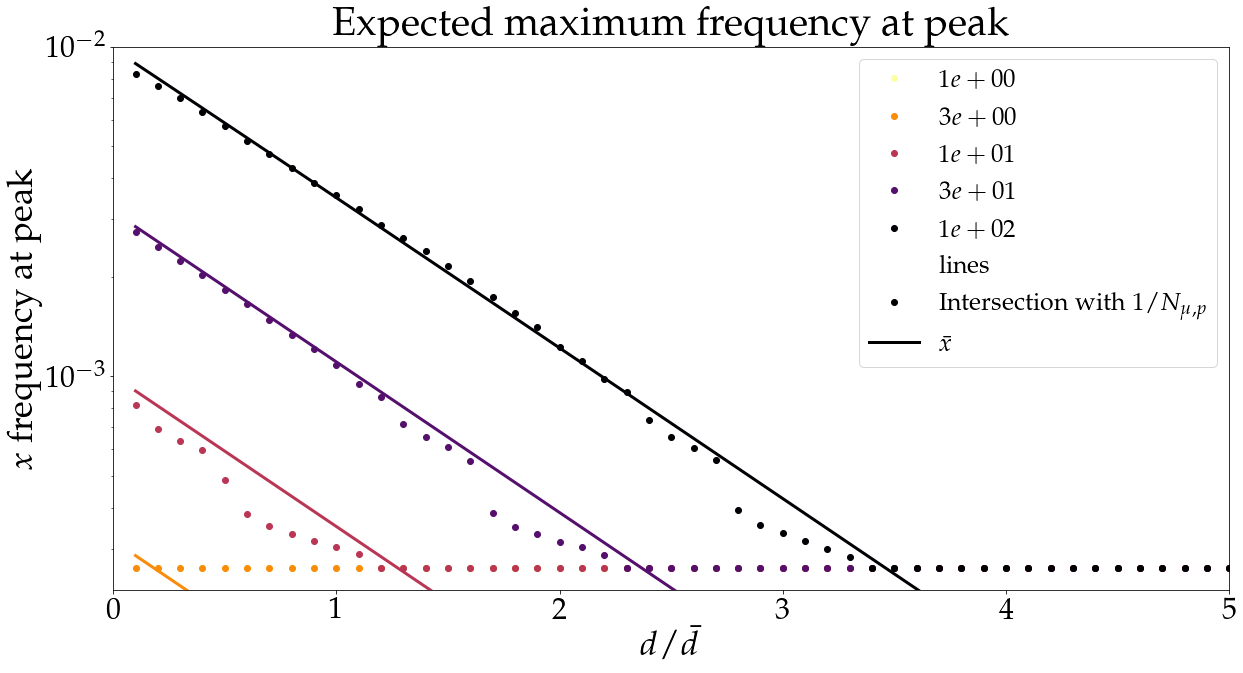

In [ ]:
%autoreload
fig,ax =plt.subplots()
beta, mu = beta_s[-1], mu_s[-1]
for mu in mu_s:
    
    double_cumulative, bins, ds = funcs.get_double_cumulative(conditioned_df, beta, mu, p_alpha)
    xbar = bins[np.argmin(np.abs(double_cumulative-1/(funcs.Nmut_single_epidemic(beta,mu,N))),axis=1)]
    xs_star = np.array([xmax(d, p_alpha, beta, mu, N, funcs.x_min_luria_dellbruck(beta,N)) for d in ds])
    ax.plot(ds*p_alpha,xbar,'o',color=colors_mu[mu], label = fr'${np.round(mu*N):.0e}$')
    ax.plot(ds*p_alpha,xs_star,color=colors_mu[mu])
handles, labels = ax.get_legend_handles_labels()
handles += [Line2D([0], [0], color='black', linestyle=''), Line2D([0], [0], color='black', linestyle='',marker='o'), Line2D([0], [0], color='black', linestyle='-')]
labels += [ 'lines' ,r'Intersection with $1/N_{\mu,p}$',r'$\bar{x}$']
ax.legend(handles, labels,loc='upper right')
ax.set_ylim(bottom=.8*funcs.x_min_luria_dellbruck(beta,N),top=.01)
ax.set_yscale('log')
ax.set_xlim(0,5)
ax.set_xlabel(r'$d/ \bar{d}$')
ax.set_ylabel(r'$x$ frequency at peak')

ax.set_title('Expected maximum frequency at peak')
plt.savefig(figures_folder+f'xbar_vs_d_beta_{beta}_mu_{mu}_N_{N}_xi_{xi}_p_alpha_{p_alpha}.jpg',dpi=300)

In [ ]:
%autoreload


avg_frequency_df = conditioned_df.groupby(['d','mu','beta', 'N', 'p_alpha']).mean().reset_index()



avg_frequency_df['scaled_d']=avg_frequency_df['d']*avg_frequency_df['p_alpha']
avg_frequency_df['logchi']=np.log(avg_frequency_df['chi'])

avg_frequency_df['theo_avg_freq']=avg_frequency_df.apply(lambda row: avg_freq_func(row['d'], row['beta'], row['mu'], row['p_alpha'], row['N']), axis=1)
avg_frequency_df['muN']=  np.round(avg_frequency_df['mu']*N)



<AxesSubplot:xlabel='d', ylabel='chi'>

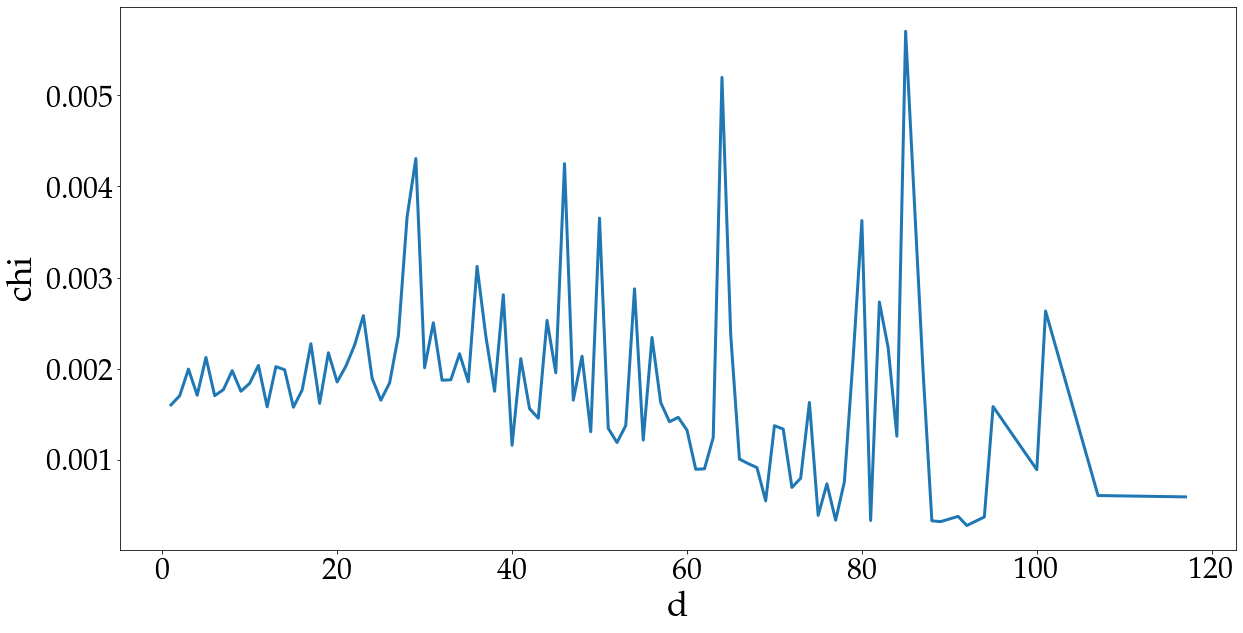

In [ ]:
qstring = 'muN==100 and beta == 3.5 and d>0' 
sns.lineplot(avg_frequency_df.query(qstring), x= 'd', y= 'chi')

In [ ]:
positive_d_df = conditioned_df.query('d>0 ')


In [ ]:
positive_d_df[positive_d_df['chi']>0.5].groupby(['mu','beta']).count().reset_index()[['mu','beta','chi']]


mu  beta  chi
0  0.000100   1.5    2
1  0.000316   1.5    3
2  0.001000   1.5    7
3  0.003162   1.5   32
4  0.003162   2.5    3
5  0.003162   3.5    1
6  0.010000   1.5   51
7  0.010000   2.5    6
8  0.010000   3.5    3

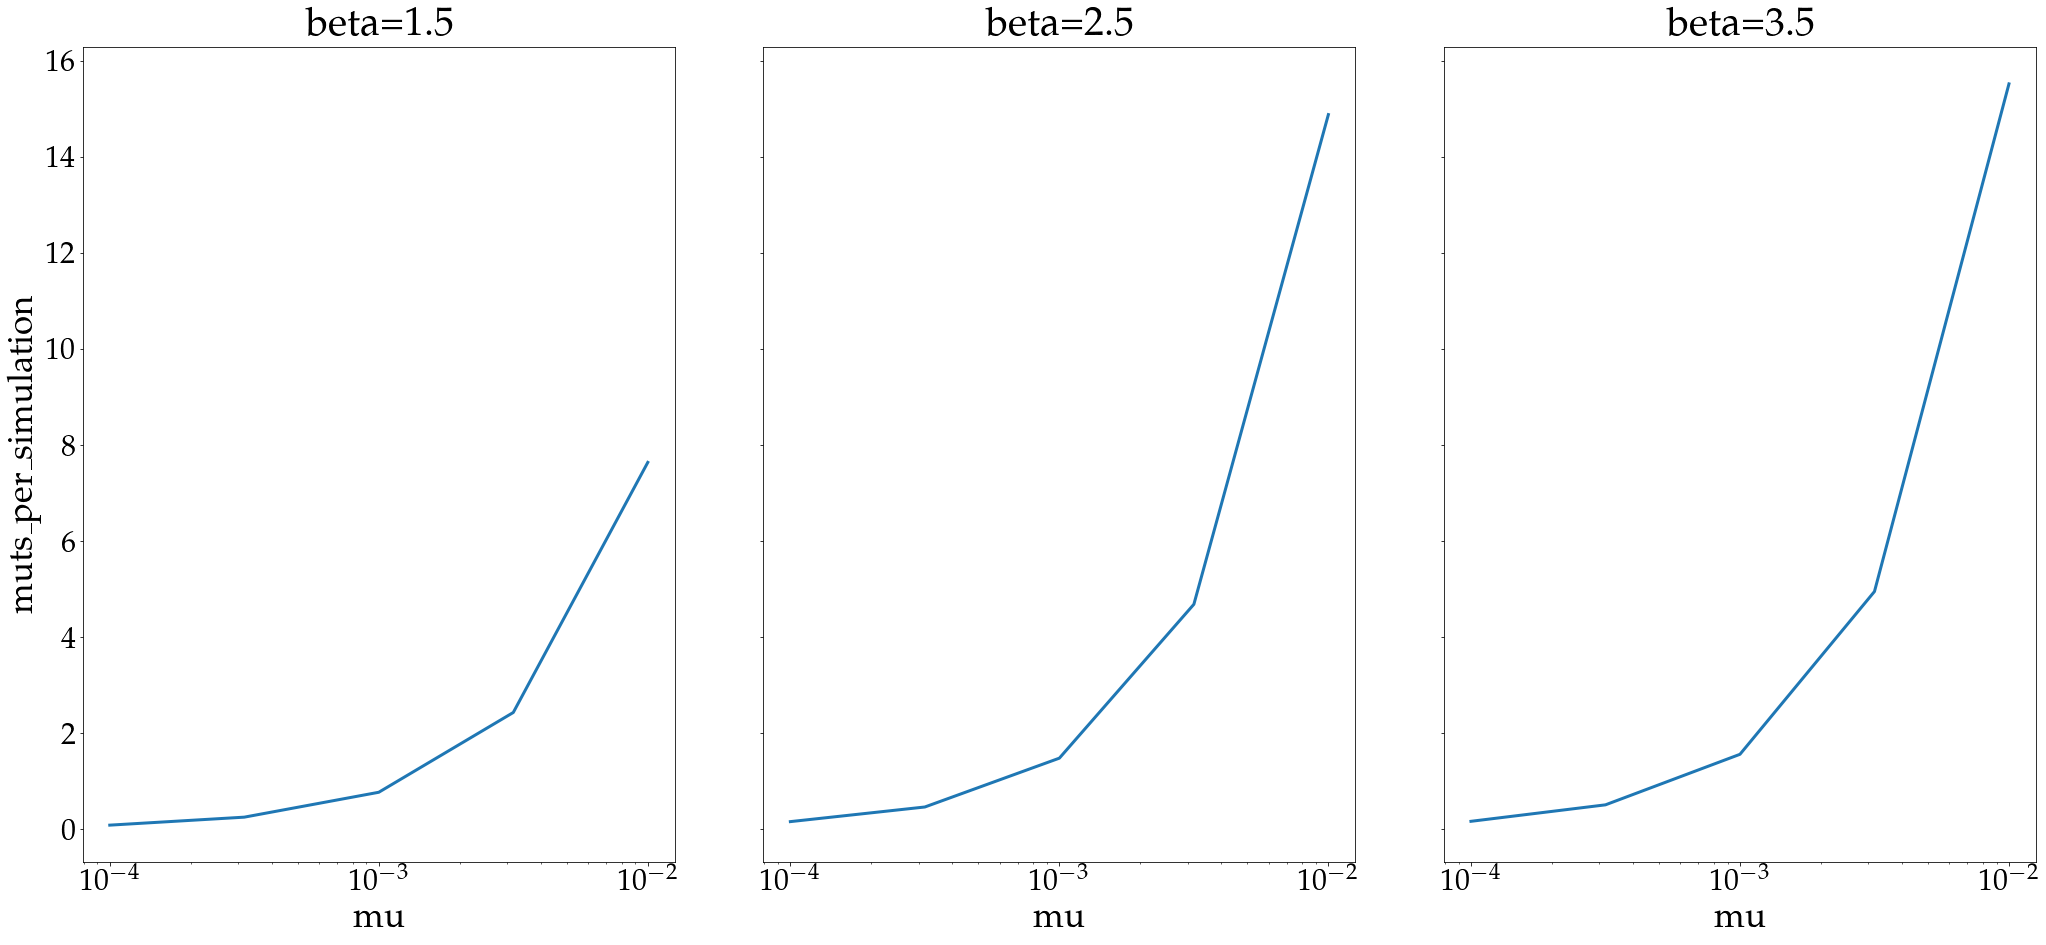

In [ ]:
N_sims = positive_d_df['n_sim'].max()
group_size = 10

def return_grouped_max_df(df,group_size):
    positive_d_df['grouped_sims'] = positive_d_df['n_sim']//group_size
    #get the maximum value of the chi column of grouped max df, grouped by the value of grouped sims and mu,beta, N, p_alpha ,ignoring the d column
    grouped_max_df = positive_d_df.groupby(['mu','beta', 'N', 'p_alpha','grouped_sims']).max().reset_index()
    return grouped_max_df



group_sizes = [10, 50, 100, 500, 1000]

# Initialize an empty list to store the resulting DataFrames
grouped_dfs = []

for group_size in group_sizes:
    
    grouped_df = return_grouped_max_df(positive_d_df,group_size)
    
    # Add the group size as a column to the grouped DataFrame
    grouped_df['group_size'] = group_size
    
    # Reset the index of the grouped DataFrame
    grouped_df.reset_index(inplace=True)
    
    # Add the grouped DataFrame to the list
    grouped_dfs.append(grouped_df)

big_grouped_df = pd.concat(grouped_dfs)
big_grouped_df['muN']=  np.round(big_grouped_df['mu']*N)



/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
Nmut_single_epidemic = lambda R0, mu, N: mu*N*np.log(R0)*(R0-1)/np.power(R0,2.35)
xmax_neutral = lambda R0, mu, N, groupsize: (1 + groupsize*Nmut_single_epidemic(R0, mu, N))/(N*(R0-1-np.log(R0))+2*groupsize*Nmut_single_epidemic(R0, mu, N))

big_grouped_df['evt_max'] = big_grouped_df.apply(lambda row: xmax_neutral(row['beta'], row['mu'], row['N'], row['group_size']), axis=1)

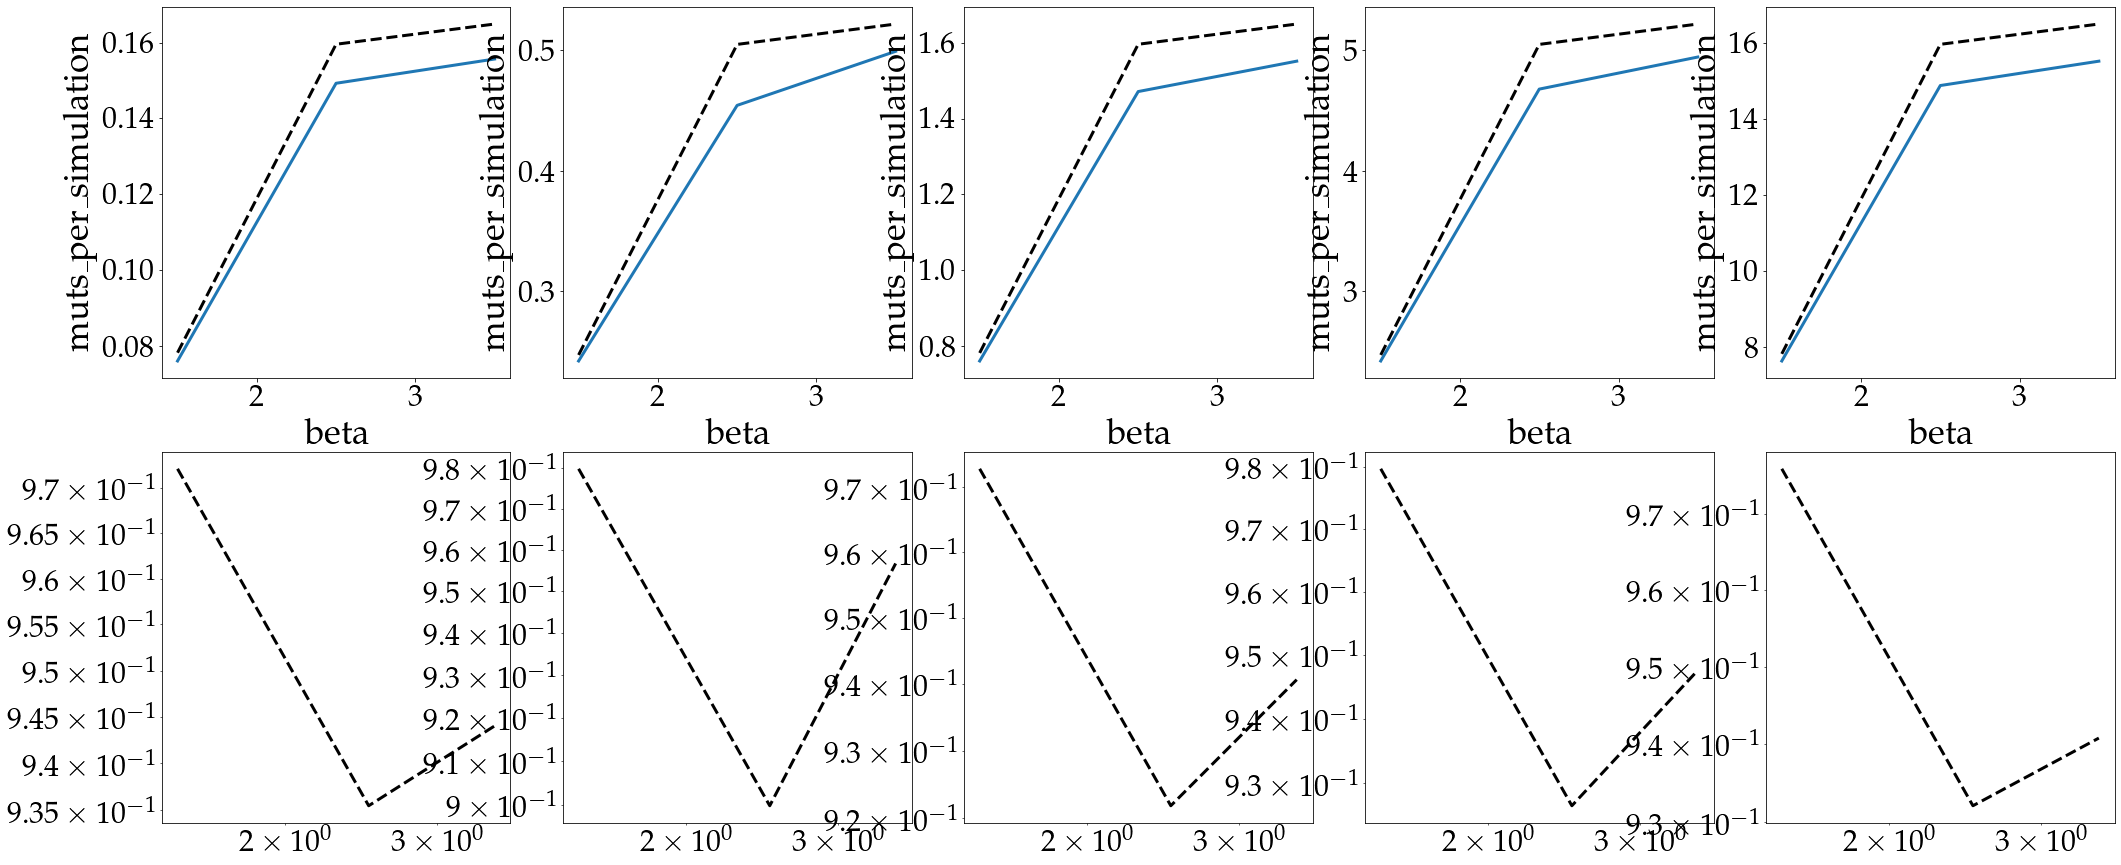

In [ ]:
tot_mutants_df = positive_d_df.groupby(['mu','beta']).count().reset_index()[['mu','beta','chi']]
tot_mutants_df['muts_per_simulation']=tot_mutants_df['chi']/6250
long_beta_s=  np.linspace(beta_s[0],beta_s[-1],100)
#plot muts per simlation in tot_mutants df in three different subplots
fig,ax = plt.subplots(2,len(mu_s),figsize=(35,15))
plt.subplots_adjust(wspace=.15)
for i_m, mu in enumerate(mu_s):
    sns.lineplot(data=tot_mutants_df.query(f'mu=={mu}'),x='beta',y='muts_per_simulation',ax=ax[0,i_m])
    ax[0,i_m].plot(beta_s,Nmut_single_epidemic(beta_s,mu,N),'--',color='black')
    ax[1,i_m].plot(beta_s, tot_mutants_df.query(f'mu=={mu}')['muts_per_simulation'].values/Nmut_single_epidemic(beta_s,mu,N),'--',color='black')
    # ax[i_m].set_title(f'beta={beta}')
    ax[1,i_m].set_xscale('log')
    ax[1,i_m].set_yscale('log')

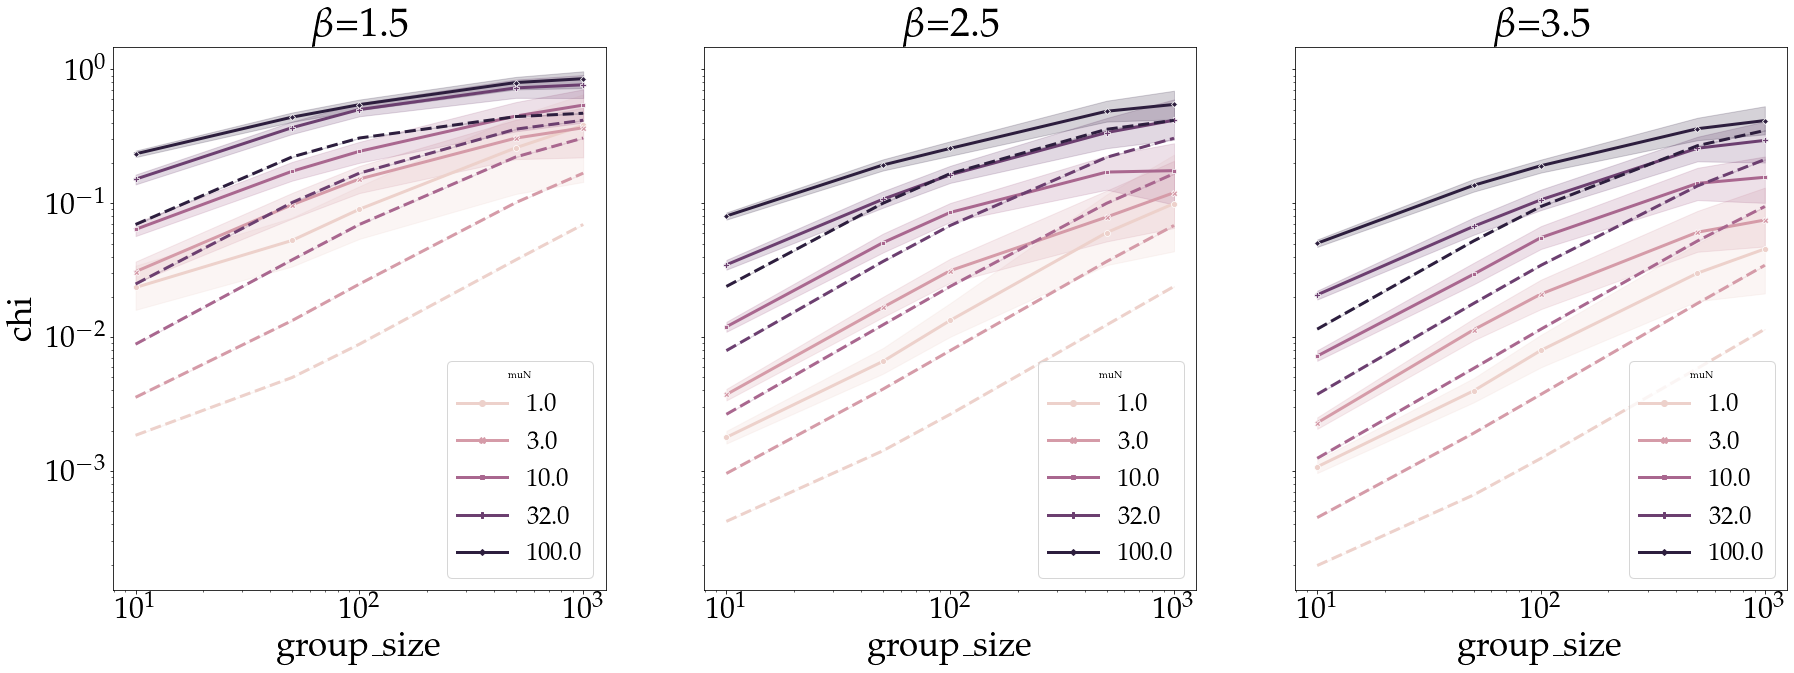

In [ ]:
#set figure size to 30,10
fig,ax = plt.subplots(1,3,figsize=(30,10),sharey=True)

for i_b,beta in enumerate(beta_s):
    sns.lineplot(big_grouped_df.query(f'beta=={beta}'),ax=ax[i_b], x='group_size', y='chi', hue='muN', style='muN', markers=True, dashes=False,hue_norm = mpl.colors.LogNorm())
    sns.lineplot(big_grouped_df.query(f'beta=={beta}'),ax=ax[i_b], x='group_size', y='evt_max', hue='muN', linestyle='--',legend=None,hue_norm = mpl.colors.LogNorm())
    ax[i_b].set_title(fr'$\beta$={beta}')
    ax[i_b].set_xscale('log')
    ax[i_b].set_yscale('log')
    

In [ ]:
grouped_max_df.query('beta==2.5 & mu==0.01 & N==10000 & p_alpha==0.1')

grouped_sims    mu  beta      N  p_alpha  xi  n_sim     d       chi  \
12               0  0.01   2.5  10000      0.1  20      9  83.0  0.091822   
26               1  0.01   2.5  10000      0.1  20     19  45.0  0.080961   
39               2  0.01   2.5  10000      0.1  20     29  44.0  0.096927   
52               3  0.01   2.5  10000      0.1  20     39  63.0  0.071273   
67               4  0.01   2.5  10000      0.1  20     49  64.0  0.075463   
...            ...   ...   ...    ...      ...  ..    ...   ...       ...   
8664           621  0.01   2.5  10000      0.1  20   6219  38.0  0.052106   
8674           622  0.01   2.5  10000      0.1  20   6229  44.0  0.129545   
8684           623  0.01   2.5  10000      0.1  20   6239  72.0  0.088663   
8694           624  0.01   2.5  10000      0.1  20   6249  63.0  0.082577   
8701           625  0.01   2.5  10000      0.1  20   6250  29.0  0.163317   

      grouped_index  
12                9  
26               19  
39               29  
52               39  
67               49  
...             ...  
8664           6219  
8674           6229  
8684           6239  
8694           6249  
8701           6250  

[626 rows x 10 columns]

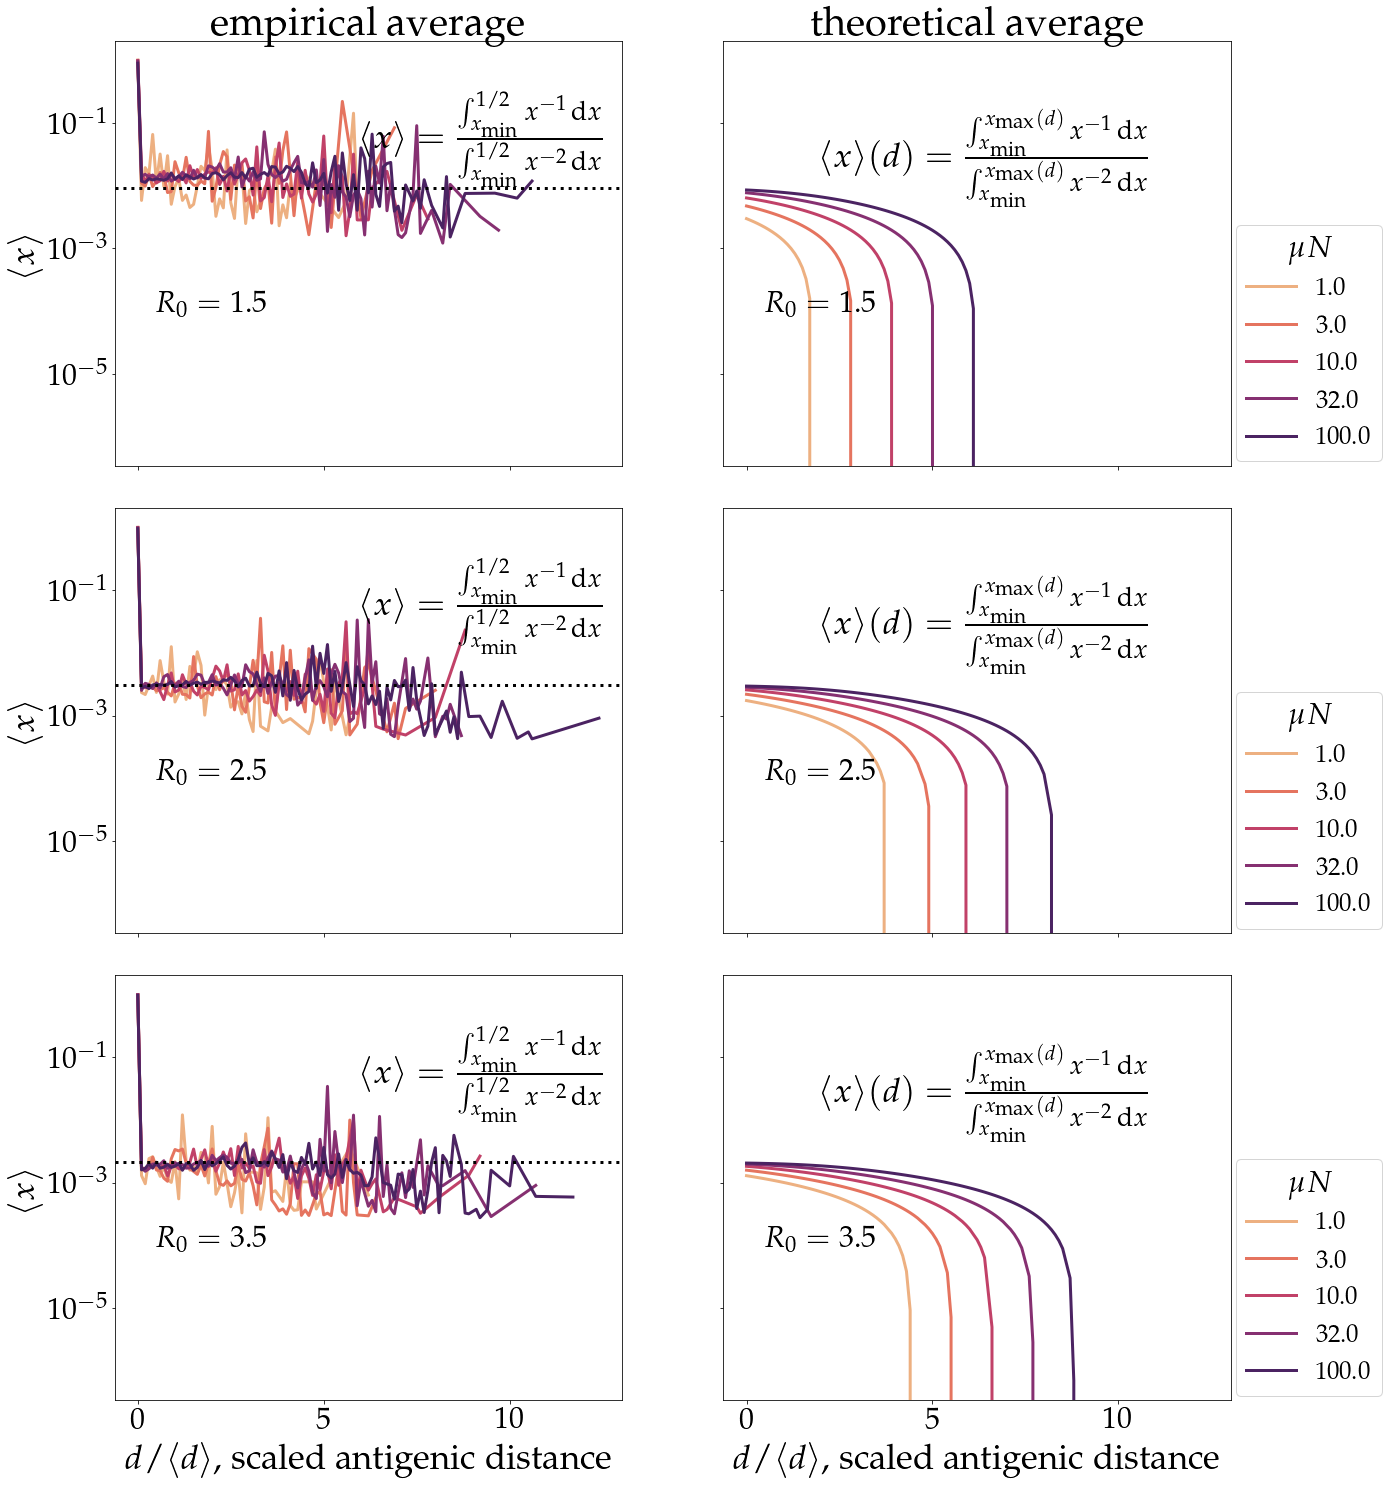

In [ ]:
fig,ax =plt.subplots(len(beta_s),2,figsize=(20,25),sharey=True,sharex=True)
plt.subplots_adjust(hspace=.1)
for i_b, beta in enumerate(beta_s):
    sns.lineplot(avg_frequency_df.query(f'beta=={beta}'), x='scaled_d', y='chi', hue='muN',ax=ax[i_b,0], palette='flare',hue_norm=mpl.colors.LogNorm(),legend=None)
    sns.lineplot(avg_frequency_df.query(f'beta=={beta}'), x='scaled_d', y='theo_avg_freq', hue='muN',ax=ax[i_b,1], palette='flare',hue_norm=mpl.colors.LogNorm())
    ax[i_b,0].annotate(fr"$R_0={beta}$", (.5,1e-4),fontsize=30)
    ax[i_b,1].annotate(fr"$R_0={beta}$", (.5,1e-4),fontsize=30)
    ax[i_b,0].axhline(-(np.log((-2*beta)/(N - N*beta + N*np.log(beta)))/(-2 + (N*(-1 + beta - np.log(beta)))/beta)),color='black',linestyle=':')

for a in ax.flatten():
    a.set_yscale('log')
    a.set_xlabel(r'$d/\langle d \rangle$, scaled antigenic distance',)
    a.set_ylabel(r'$\langle x\rangle$',)

ax[0,0].set_title(fr'empirical average')
ax[0,1].set_title(fr'theoretical average')

for a in ax[:,0]:
    a.annotate(r'$\langle x \rangle = \frac{\int_{x_\mathrm{min}}^{1/2} x^{-1}  \, \mathrm{d}x}{\int_{x_\mathrm{min}}^{1/2} x^{-2}  \, \mathrm{d}x}$', (6,.04),fontsize=35
               )


for a in ax[:,1]:
    a.legend(title=r'$\mu N$', title_fontsize=30,loc=(1.01,.01))
    a.annotate(r'$\langle x \rangle (d)= \frac{\int_{x_\mathrm{min}}^{x_\mathrm{max}(d)} x^{-1}  \, \mathrm{d}x}{\int_{x_\mathrm{min}}^{x_\mathrm{max}(d)} x^{-2}  \, \mathrm{d}x}$', (2,.02),fontsize=35
               )
    
# plt.savefig(figures_folder+'x_avg_recap.jpg',bbox_inches='tight')

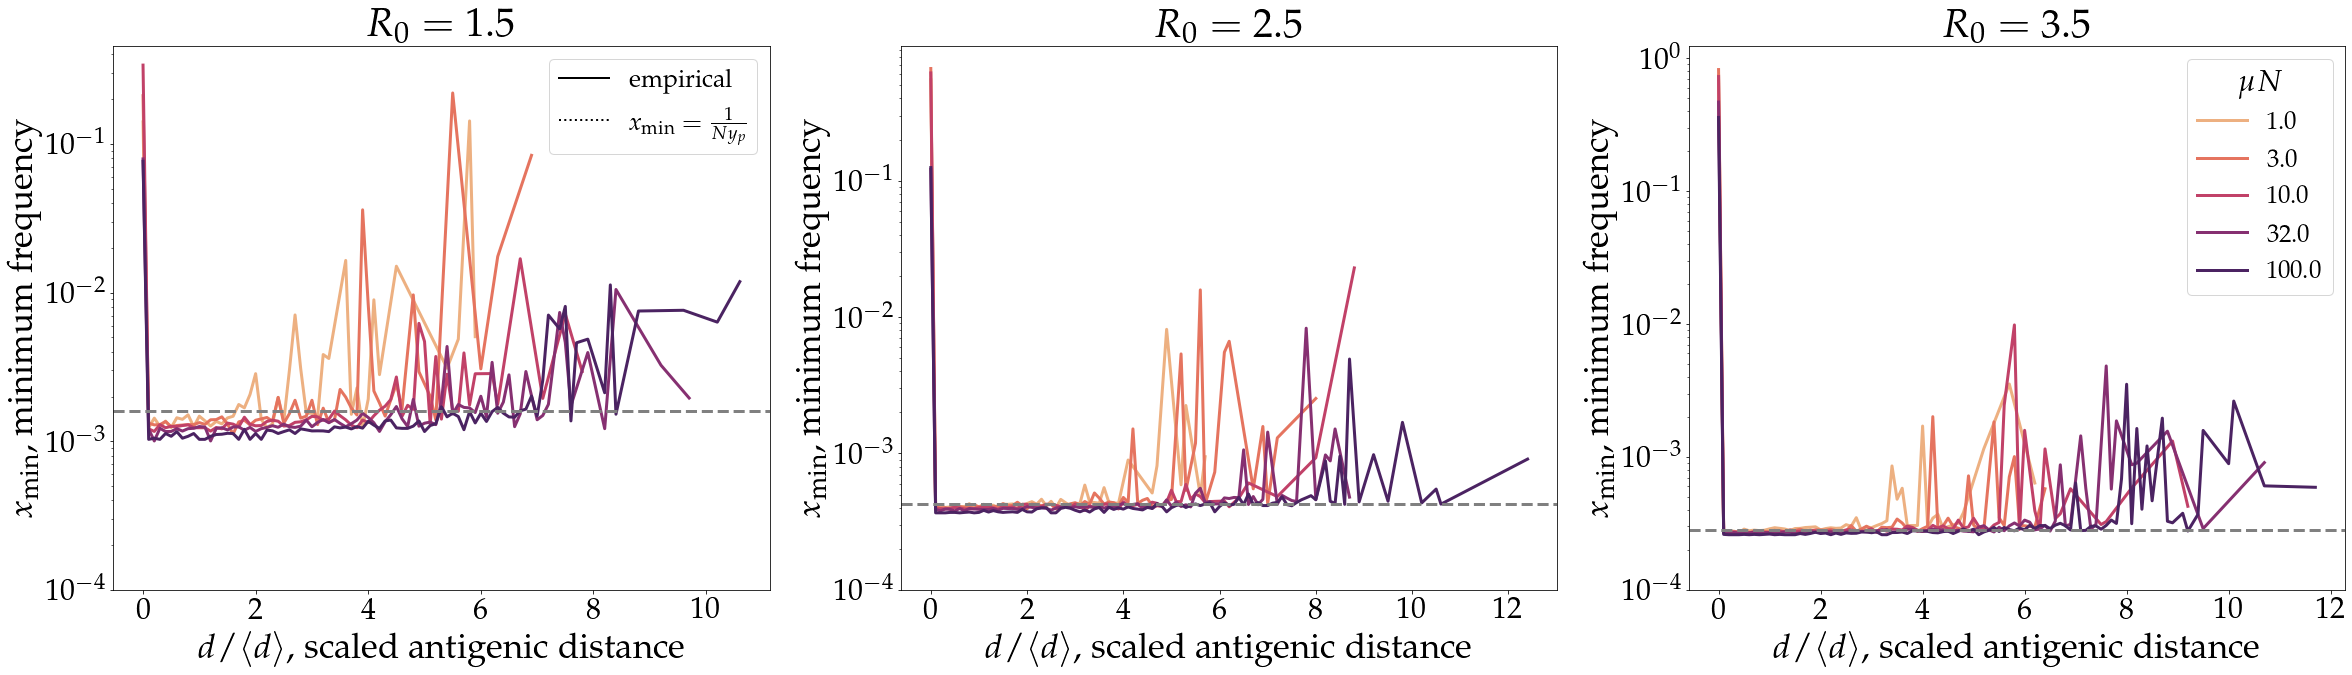

In [ ]:
min_df = conditioned_df.groupby(['mu','beta','d']).min().reset_index()
min_df['scaled_d']= min_df['d']*p_alpha
min_df['muN']= np.round(min_df['mu']*N)
fig,ax =plt.subplots(1,len(beta_s),figsize=(40,10),sharey=False)
for i_b, beta in enumerate(beta_s):
    min_ds = np.array(list(set(min_df['d'])))
    if i_b<len(beta_s)-1:
        legend=None
    else:
        legend='auto'
    sns.lineplot(min_df.query(f'beta=={beta}'), x='scaled_d', y='chi', hue='muN',ax=ax[i_b], palette='flare',hue_norm=mpl.colors.LogNorm(),legend=legend)
    ax[i_b].axhline(beta/(N*(beta-1-np.log(beta))),color='grey',linestyle='--')
    ax[i_b].set_title(fr'$R_0={beta}$')

for i_b,a in enumerate(ax):
    a.set_yscale('log')
    a.set_ylim(bottom=1e-4)
    a.set_xlabel(r'$d/\langle d \rangle$, scaled antigenic distance',)
    a.set_ylabel(r'$x_\mathrm{min}$, minimum frequency ',)
    if i_b>len(beta_s)-2:
        a.legend(title=r'$\mu N$', title_fontsize=30)

custom_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle='-'),
    Line2D([0], [0], color='black', lw=2, linestyle=':')
]

# Add the custom legend to the plot
ax[0].legend(custom_lines, ['empirical',r"$x_\mathrm{min}= \frac{1}{N y_p}$"])

plt.savefig(figures_folder+'x_min_recap.jpg',bbox_inches='tight')        

In [ ]:
colors_mu

{0.0001: array([0.92907237, 0.68878959, 0.50411509, 1.        ]),
 0.00031622776601683794: array([0.89737819, 0.44322747, 0.37043052, 1.        ]),
 0.001: array([0.75861834, 0.25356035, 0.40663694, 1.        ]),
 0.0031622776601683794: array([0.52386353, 0.18939409, 0.44182449, 1.        ]),
 0.01: array([0.29408557, 0.13721193, 0.38442775, 1.        ])}

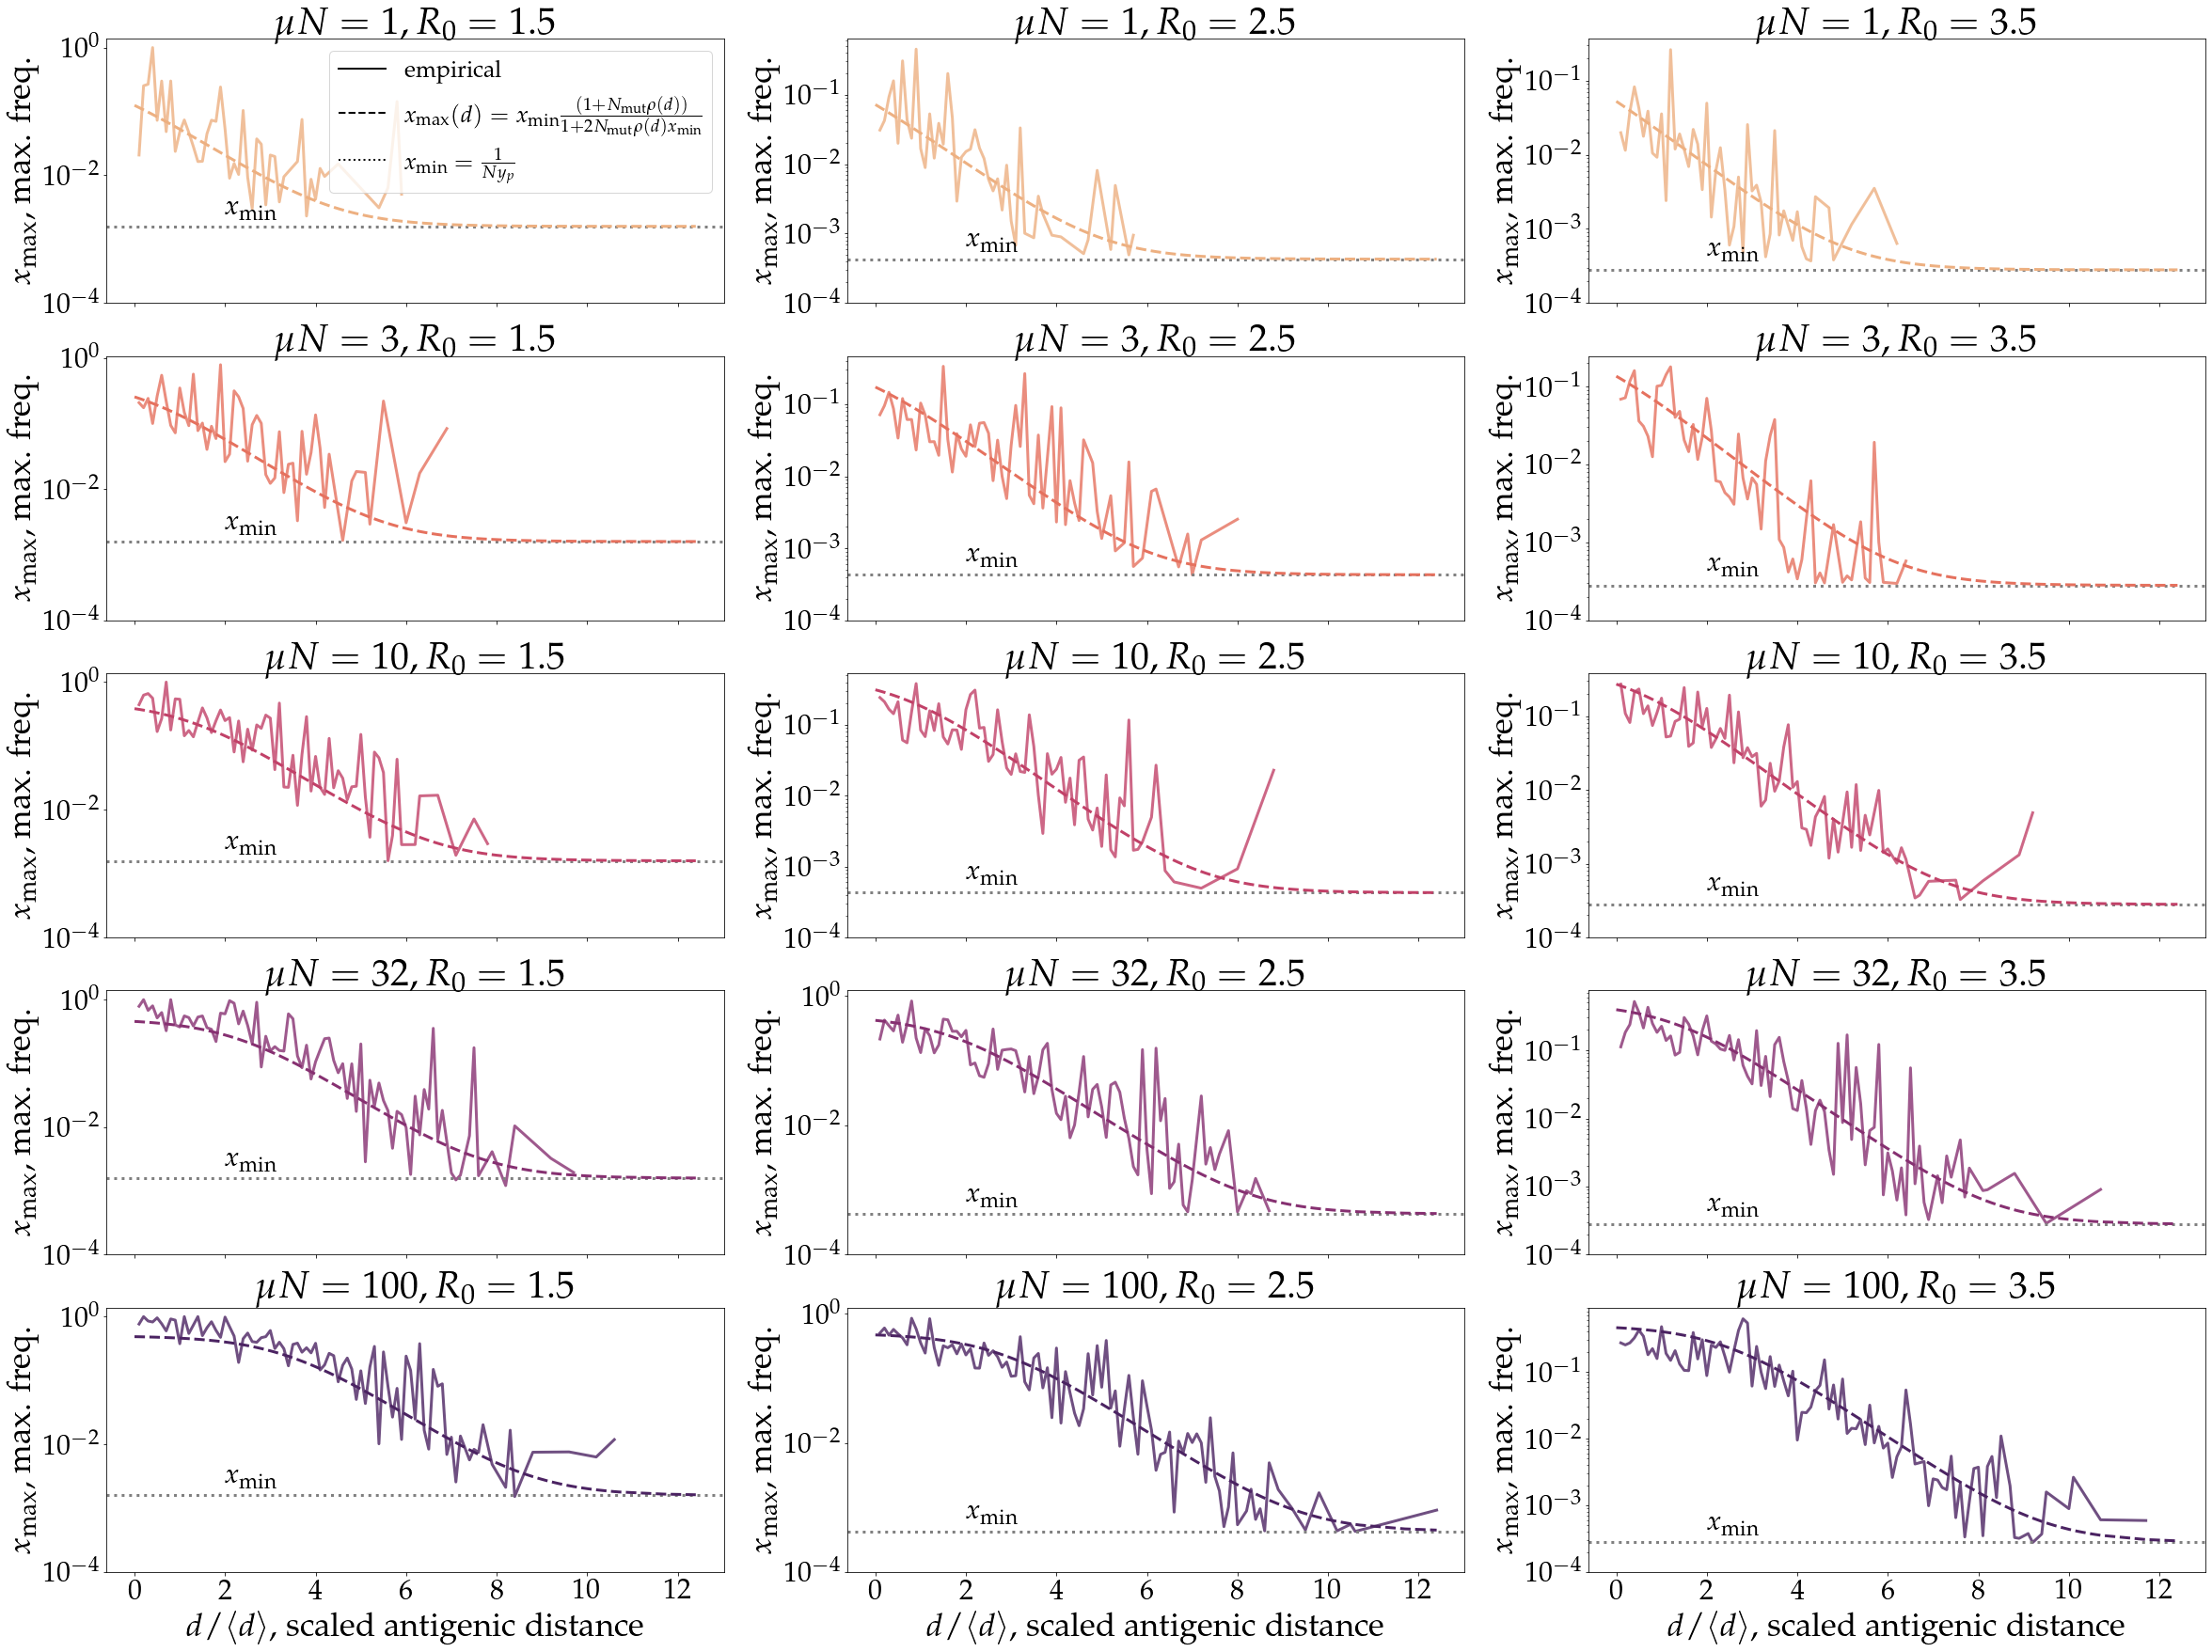

In [ ]:
%autoreload
max_df = conditioned_df.groupby(['mu','beta','d']).max().reset_index()
max_df['scaled_d']= max_df['d']*p_alpha
max_df['muN']= np.round(max_df['mu']*N)
N_sim = 6250
colors_mu = dict(zip(mu_s,sns.color_palette("flare", as_cmap=True)(np.linspace(0,1,len(mu_s)))))
fig,ax =plt.subplots(len(mu_s),len(beta_s),figsize=(40,30),sharey=False,sharex=True)
plt.subplots_adjust(hspace=.2)
for i_b, beta in enumerate(beta_s):
    max_ds = np.array(list(set(max_df['d'])))

    
    x_min = funcs.x_min_luria_dellbruck(beta,N)
    for i_m,mu in enumerate(mu_s):
        sns.lineplot(max_df.query(f'beta=={beta} and mu=={mu} and d>0'), x='scaled_d', y='chi', ax=ax[i_m,i_b],alpha=.8,legend=False,color=colors_mu[mu])
        ax[i_m,i_b].axhline(beta/(N*(beta-1-np.log(beta))),color='grey',linestyle=':')
        N_mut_per_sim = funcs.Nmut_single_epidemic(beta,mu,N)
        x_maxes = [funcs.x_max_of_Nmut(d,N_sim*N_mut_per_sim,beta,N,p_alpha) for d in min_ds]
        ax[i_m,i_b].plot(min_ds*p_alpha, x_maxes ,linestyle='--',color=colors_mu[mu])
        #annotate x_min at (2,1.5*x_min)
        ax[i_m,i_b].annotate(fr'$x_\mathrm{{min}}$', (2,1.5*x_min),fontsize=30)
    
ax = ax.flatten()
for i,x in enumerate(funcs.product(mu_s,beta_s)):
    ax[i].set_yscale('log')
    ax[i].set_ylim(bottom=1e-4)
    ax[i].set_xlabel(r'$d/\langle d \rangle$, scaled antigenic distance',)
    ax[i].set_ylabel(r'$x_\mathrm{max}$, max. freq.',)
    ax[i].set_title(fr'$\mu N={np.round(x[0]*N):.0f}, R_0={x[1]}$')
#     if i_b>len(beta_s)-2:
#         a.legend(title=r'$\mu N$', title_fontsize=30)

custom_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle='-'),
    Line2D([0], [0], color='black', lw=2, linestyle='--'),
    Line2D([0], [0], color='black', lw=2, linestyle=':'),
]

# Add the custom legend to the plot
ax[0].legend(custom_lines, ['empirical', r'$x_\mathrm{max}(d) = x_\mathrm{min} \frac{\left(1 +N_\mathrm{mut}\rho(d)\right)}{1 + 2N_\mathrm{mut}\rho(d) x_\mathrm{min}}$',r"$x_\mathrm{min}= \frac{1}{N y_p}$"])

plt.savefig(figures_folder+'x_max_recap.jpg',bbox_inches='tight')        


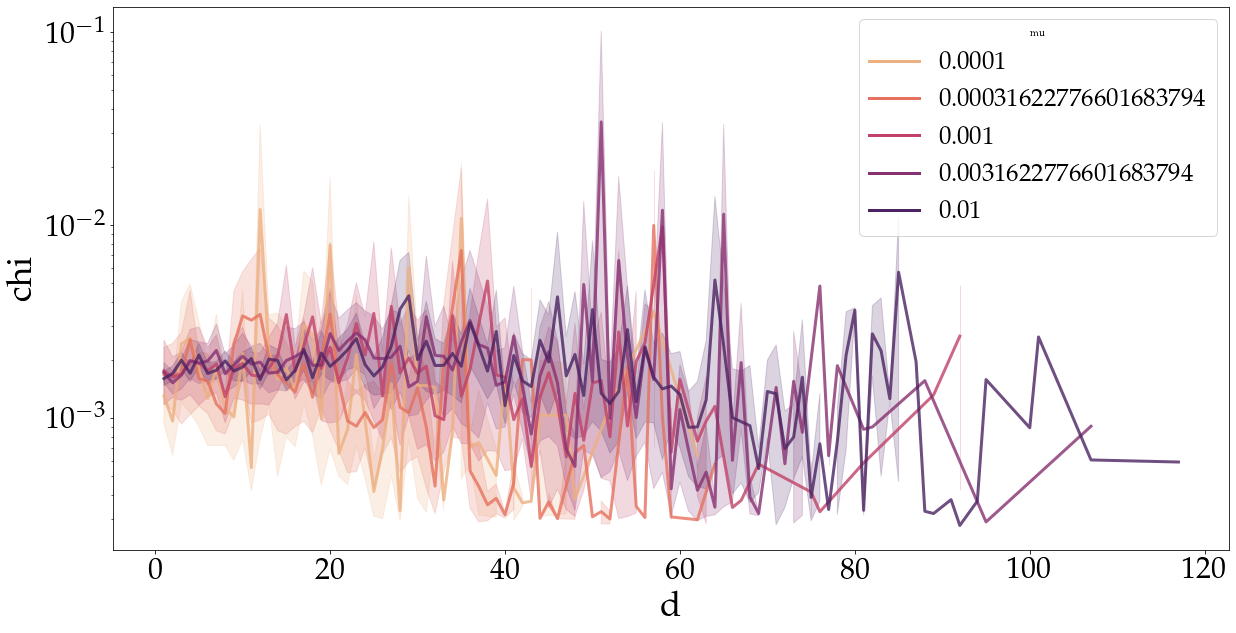

In [ ]:
fig,ax =plt.subplots()

sns.lineplot(conditioned_df.query(f'beta=={beta}'), x='d', y='chi', hue='mu', palette='flare',hue_norm=mpl.colors.LogNorm(),alpha=.8,legend=legend,ax=ax)
ax.set_yscale('log')


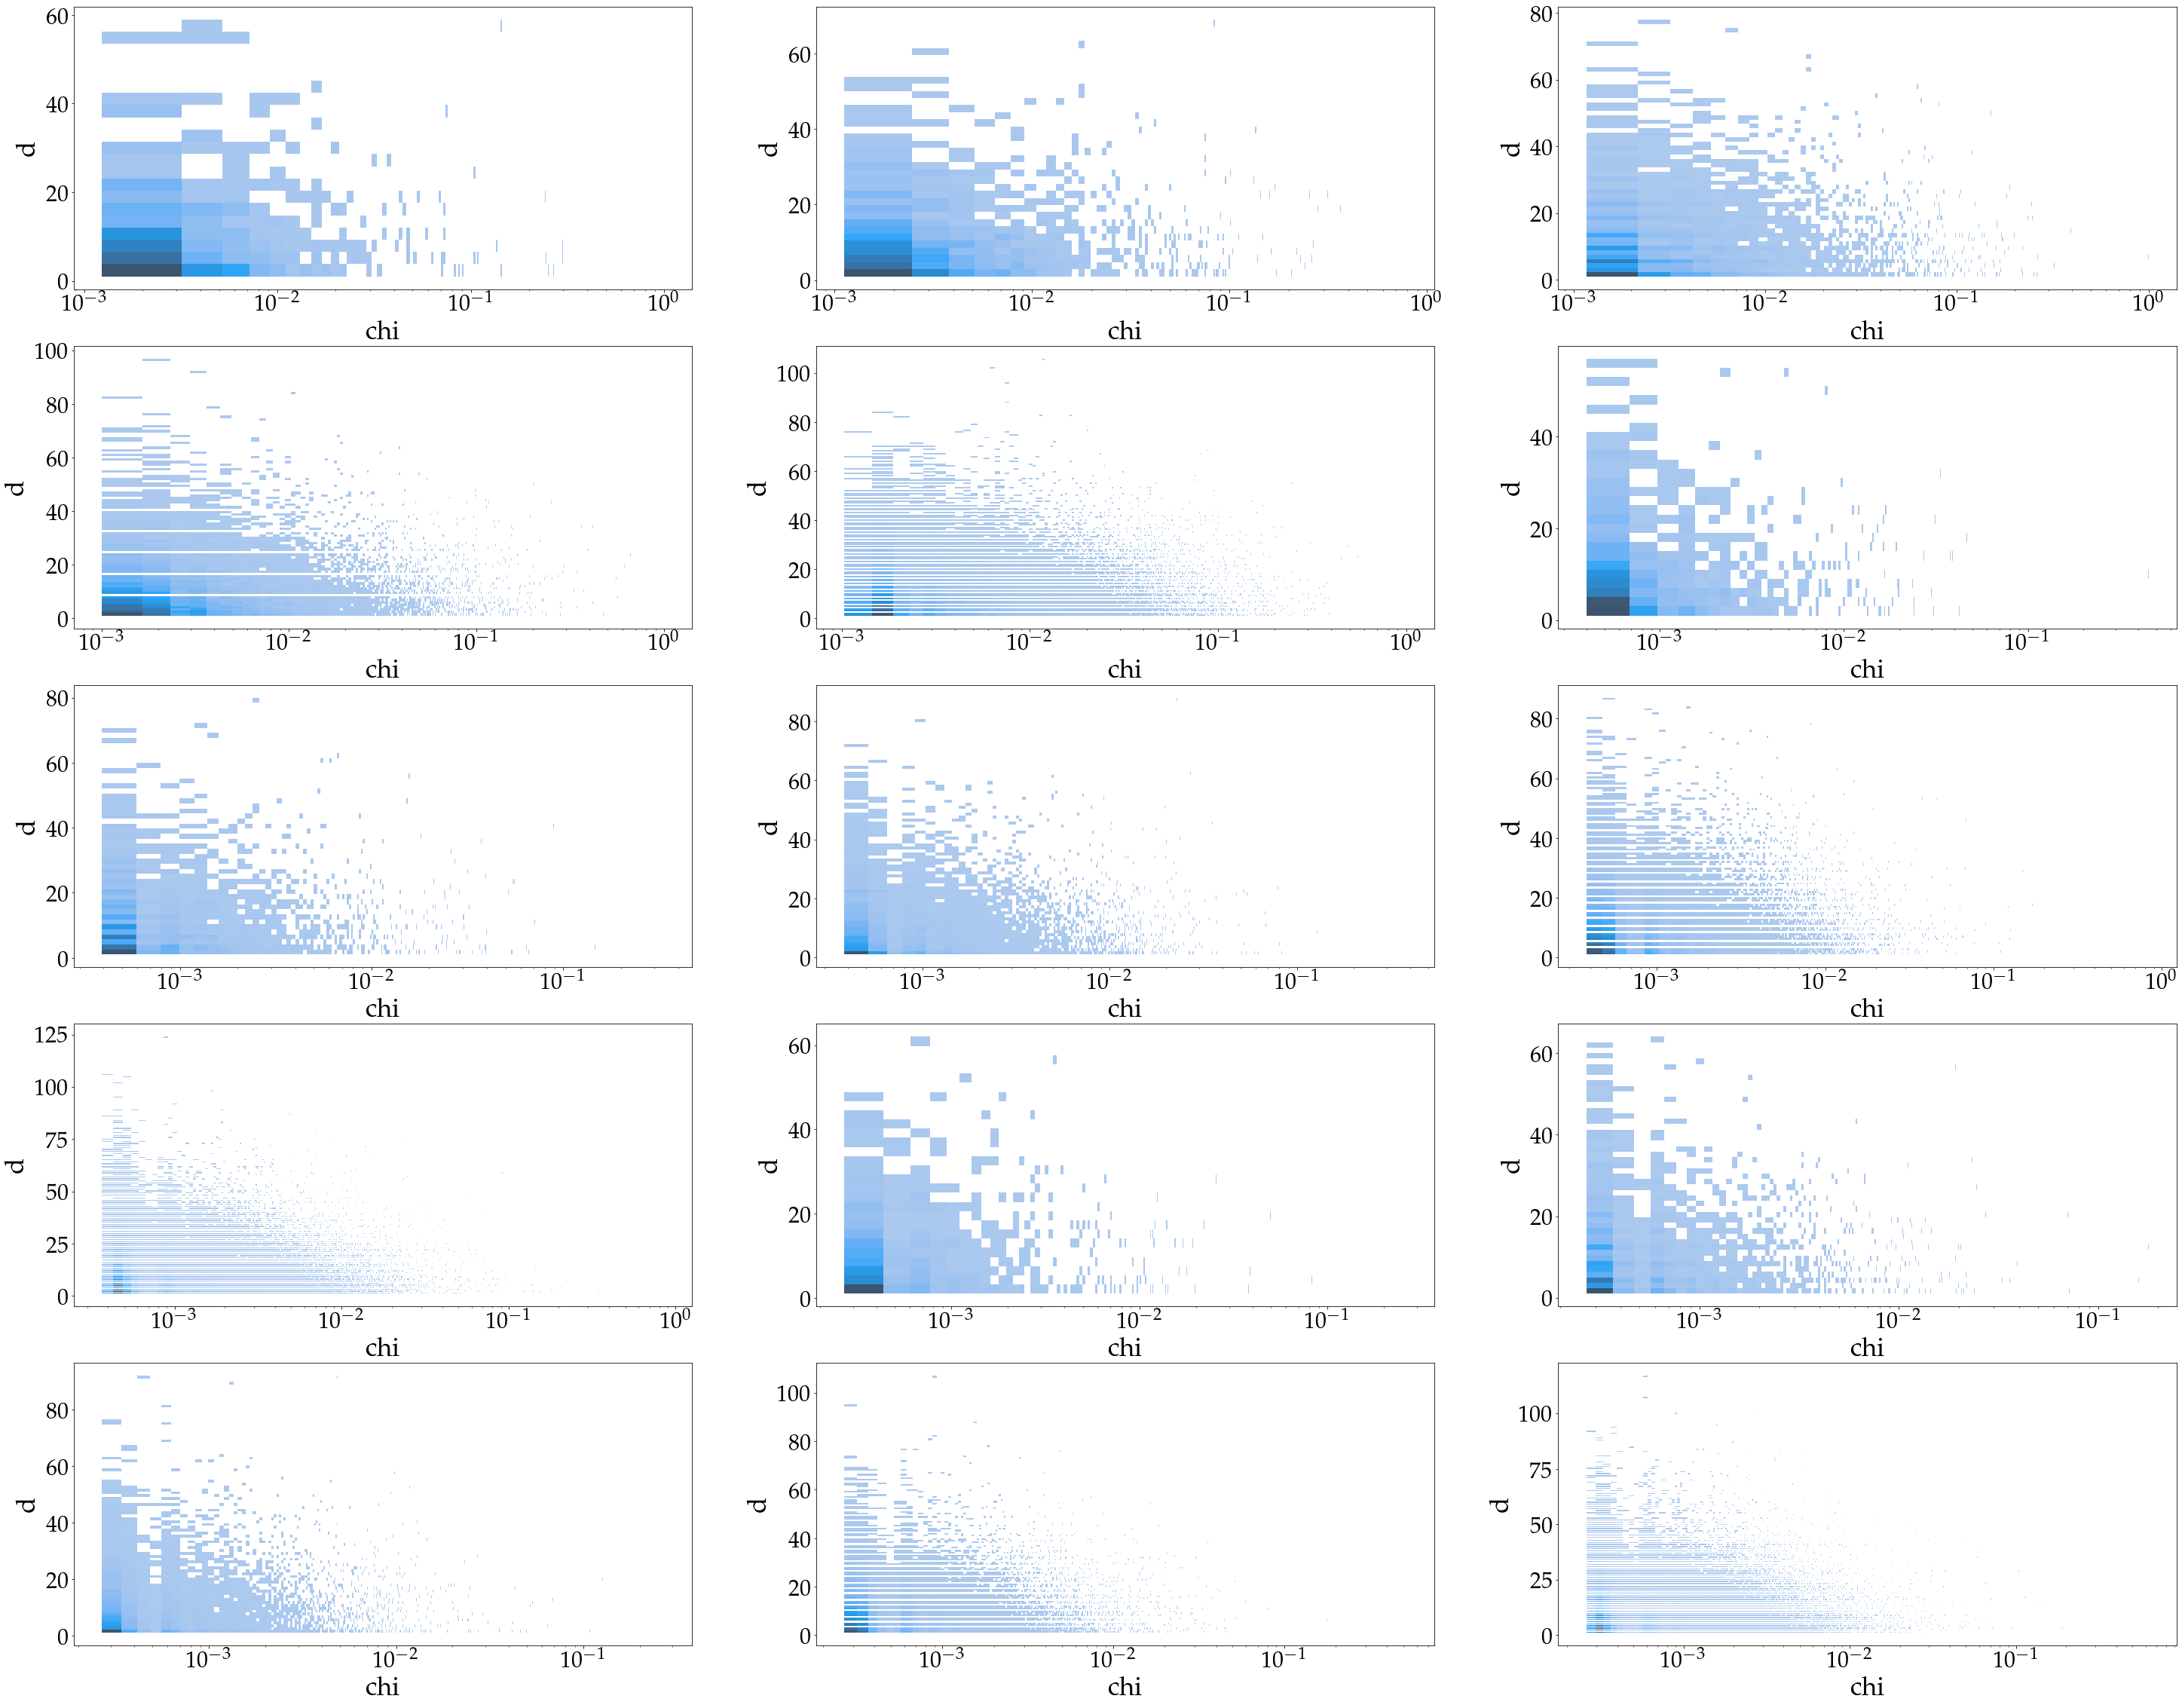

In [ ]:
fig,ax =plt.subplots(len(mu_s),len(beta_s), figsize=(50,40))
ax=ax.flatten()
for i_x, x in enumerate(product(beta_s,mu_s)):
    beta, mu = x 
    qstring = f"beta=={beta} & mu=={mu}"
    sns.histplot(conditioned_df.query(qstring), x='chi', y='d',ax=ax[i_x])
    ax[i_x].set_xscale('log')

In [ ]:
conditioned_df['logchi'] = np.log(conditioned_df['chi'])

In [ ]:
averages = conditioned_df.query(f'beta=={beta}').groupby(['d','mu']).mean().groupby(['beta','mu']).mean()['logchi'].values
averages.flatten()

array([-7.15227884, -7.41150395, -7.1978514 , -7.22184532, -7.18685334])

[array([0.267004, 0.004874, 0.329415, 1.      ]),
 array([0.229739, 0.322361, 0.545706, 1.      ]),
 array([0.127568, 0.566949, 0.550556, 1.      ]),
 array([0.369214, 0.788888, 0.382914, 1.      ]),
 array([0.993248, 0.906157, 0.143936, 1.      ]),
 array([0.267004, 0.004874, 0.329415, 1.      ]),
 array([0.229739, 0.322361, 0.545706, 1.      ]),
 array([0.127568, 0.566949, 0.550556, 1.      ]),
 array([0.369214, 0.788888, 0.382914, 1.      ]),
 array([0.993248, 0.906157, 0.143936, 1.      ]),
 'C0',
 'C0',
 'C0',
 'C0',
 'C0']

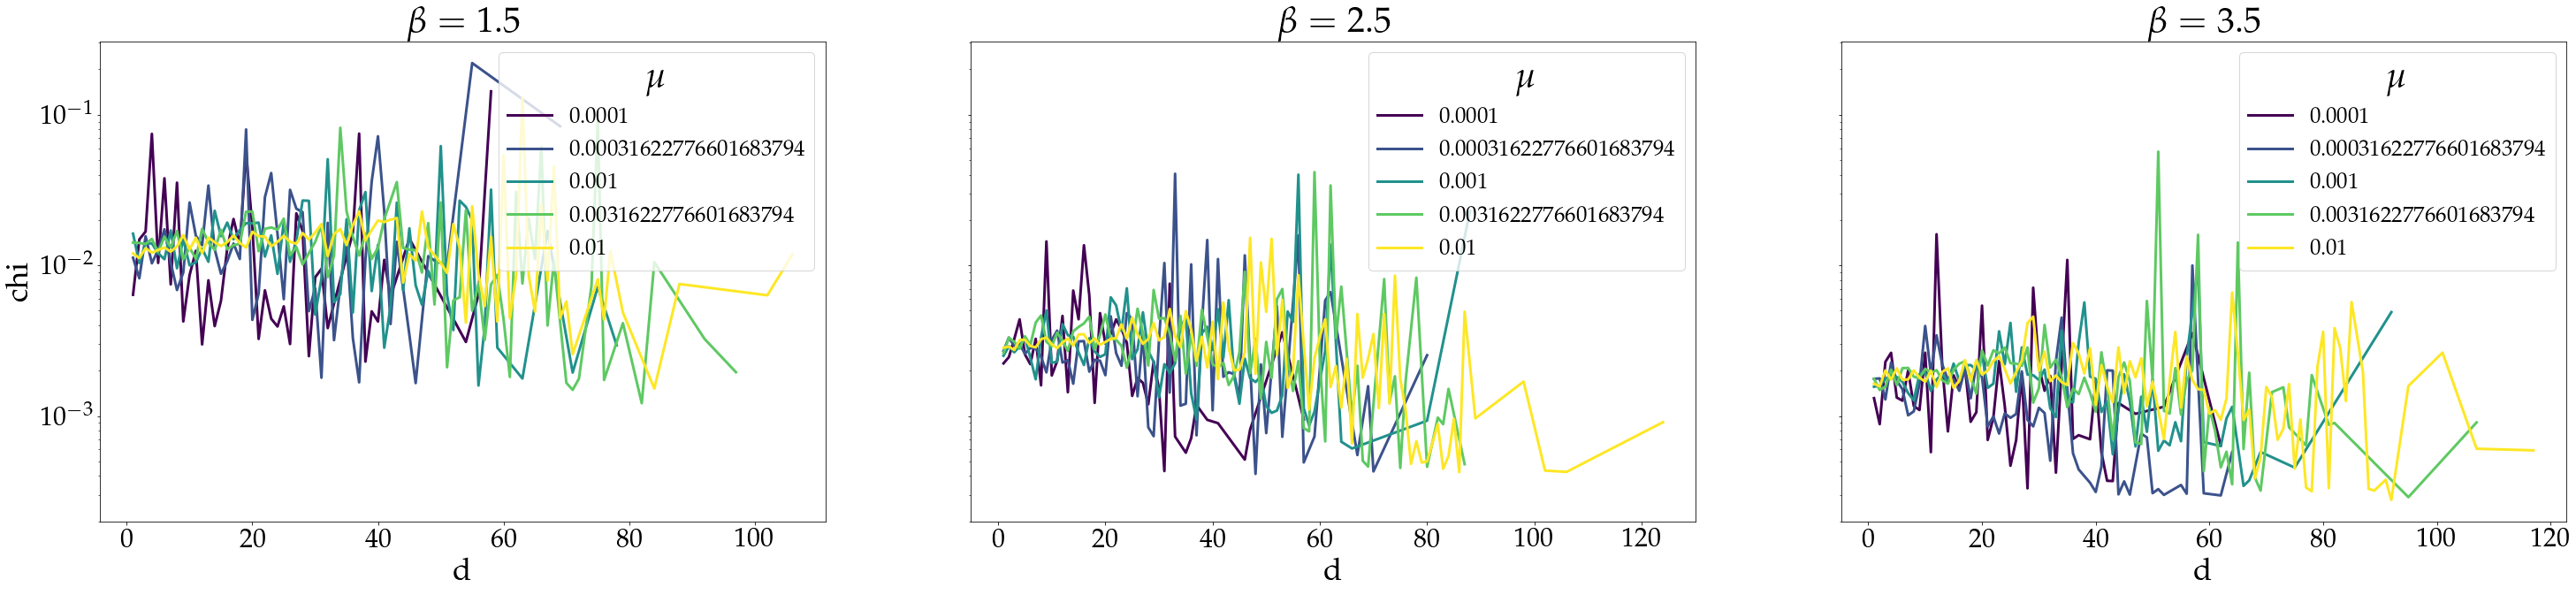

In [ ]:
fig,ax =plt.subplots(1,3,figsize=(50,10),sharey=True)
avgs = []
for i_b, beta in enumerate(beta_s):
    beta_grouped_df = conditioned_df.query(f'beta=={beta}').groupby(['d','mu']).mean()
    l = sns.lineplot(data=beta_grouped_df,x='d',y='chi', hue='mu',palette="viridis",hue_norm=mpl.colors.LogNorm(), ax = ax[i_b])
    averages = conditioned_df.query(f'beta=={beta}').groupby(['d','mu']).mean().groupby(['beta','mu']).mean()['logchi'].values.flatten()
    # [ax[i_b].axhline(a) for a in averages]
    # avgs.append(averages)

for i_b,a in enumerate(ax):
    a.set_yscale('log')
    a.legend(title=r'$\mu$',title_fontsize=40)
    a.set_title(fr'$\beta={beta_s[i_b]}$')
    # a.set_ylim(np.array(a.get_ylim())/3)

avgs= np.array(avgs)

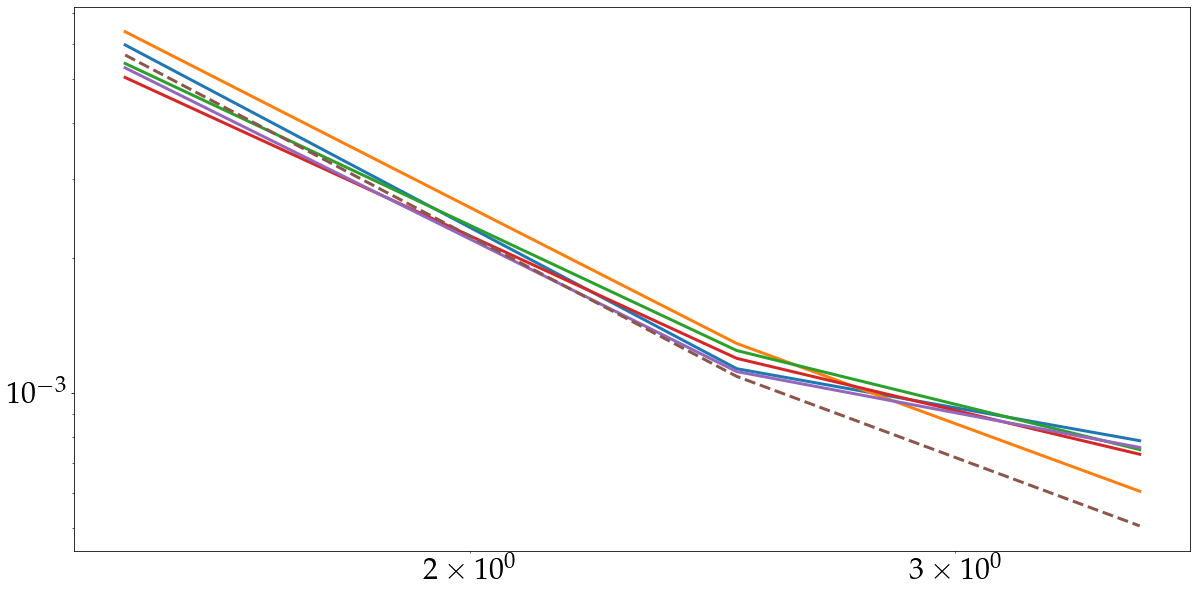

In [ ]:
for a in avgs.T:
    plt.plot(beta_s,np.exp(a))
plt.plot(beta_s, 1/(500*(beta_s-1)**1.5),linestyle='--')
plt.xscale('log')
plt.yscale('log')

In [ ]:
test= beta_grouped_df.groupby(['beta','mu']).mean()['logchi'].mean()
[plt.axhline(t) for t in test]
plt.yscale('log')

TypeError: 'float' object is not iterable

In [ ]:
test

chi    logchi
beta mu                          
3.5  0.000100  0.002048 -6.625275
     0.000316  0.001423 -6.896589
     0.001000  0.001811 -6.520306
     0.003162  0.002706 -6.446598
     0.010000  0.001817 -6.493937

In [ ]:
beta,mu = beta_s[-1], mu_s[-1]
d = 1
qstring =get_query_string((beta,mu,d),('beta','mu', 'd'))

len(conditioned_df.query(qstring))

7694

In [ ]:
dmax = max(conditioned_df['d'])
N = 1e4
p_alpha=.1
Nreps = 5000
rho_d = lambda d,p_alpha: p_alpha*np.power(1-p_alpha,d-1)
counts_dict = {}

for i_x,x in enumerate(product(np.arange(1,dmax+1),mu_s,beta_s)):
    d,mu,beta =x
    qstring =get_query_string((beta,mu,d),('beta','mu', 'd'))
    theory_counts = Nreps* mu*N*np.log(beta)/beta * rho_d(d,p_alpha)
    counts_dict[i_x] = [beta,mu, d, len(conditioned_df.query(qstring)),theory_counts]
    

In [ ]:
counts_df=  pd.DataFrame.from_dict(counts_dict,orient='index',columns=['beta','mu','d','counts','theory_counts'])

In [ ]:
import matplotlib as mpl

counts_df['muN']=np.round(counts_df['mu']*N,1)
counts_df['test_theory']=counts_df['theory_counts']*(counts_df['beta']-1)/counts_df['beta']
counts_df['fraction']=counts_df['test_theory']/counts_df['counts']

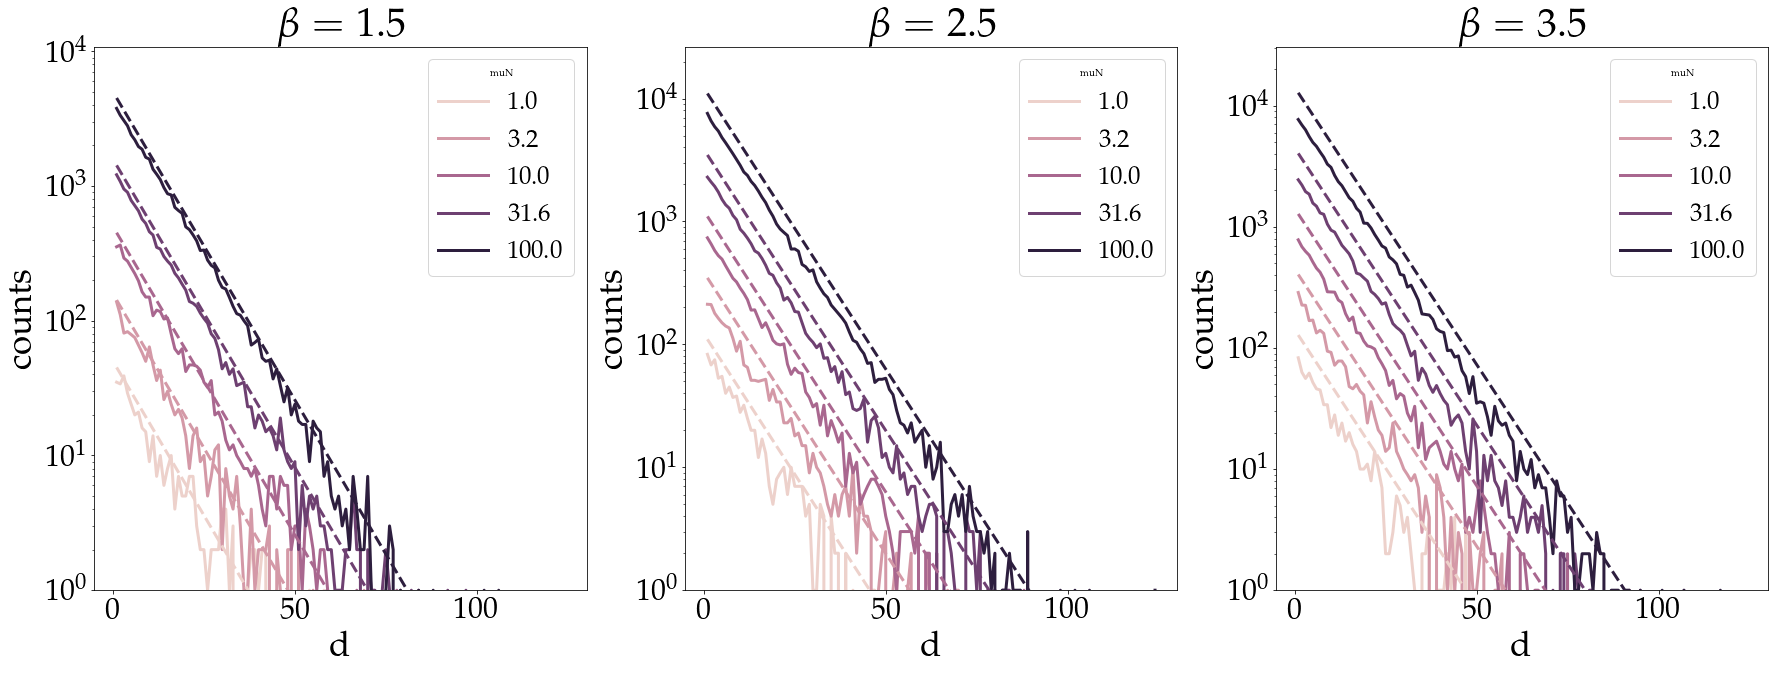

In [ ]:
fig,ax =plt.subplots(1,3,figsize=(30,10))

beta,mu = beta_s[-1], mu_s[-1]

for i_b,beta in enumerate(beta_s):
    qstring =f'beta=={beta}'
    sns.lineplot(counts_df.query(qstring),x='d',y='counts',ax=ax[i_b],hue='muN', hue_norm=mpl.colors.LogNorm())
    sns.lineplot(counts_df.query(qstring),x='d',y='test_theory',ax=ax[i_b],hue='muN', hue_norm=mpl.colors.LogNorm(),linestyle='--',legend=None)
    ax[i_b].set_yscale('log')
    ax[i_b].set_ylim(bottom=1)
    ax[i_b].set_title(fr'$\beta={beta}$')



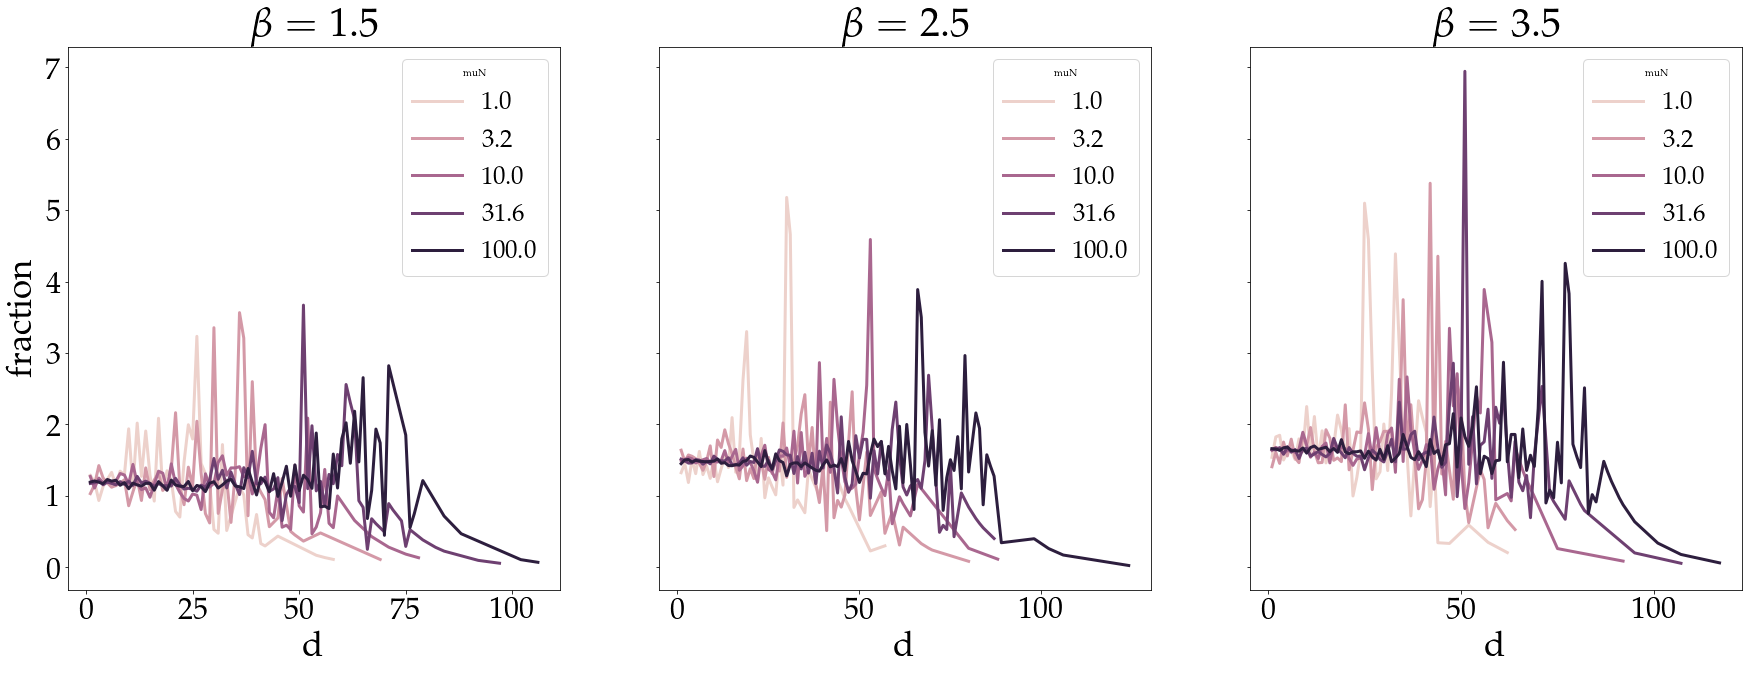

In [ ]:
fig,ax =plt.subplots(1,3,figsize=(30,10),sharey=True)

beta,mu = beta_s[-1], mu_s[-1]

for i_b,beta in enumerate(beta_s):
    qstring =f'beta=={beta}'
    sns.lineplot(counts_df.query(qstring),x='d',y='fraction',ax=ax[i_b],hue='muN', hue_norm=mpl.colors.LogNorm())
    ax[i_b].set_title(fr'$\beta={beta}$')

In [ ]:
conditioned_dict

{12.0: [0.033846153846153845,
  0.0,
  0.00030845157310302283,
  0.0,
  0.0026556506344054295,
  0.00029507229271171436,
  0.00029507229271171436,
  0.0005995203836930455,
  0.0122306348281887,
  0.00029120559114735004,
  0.0,
  0.0009107468123861566,
  0.00030358227079538557,
  0.0005825808330905913,
  0.00029129041654529564,
  0.0,
  0.0,
  0.012863705972434915,
  0.00030627871362940275,
  0.00030627871362940275,
  0.0006011421701232341,
  0.00030057108506161706,
  0.00030057108506161706,
  0.0008860011813349084,
  0.00029533372711163615,
  0.0003290556103981573,
  0.0003290556103981573,
  0.00030826140567200987,
  0.0038819875776397515,
  0.0,
  0.0006091989034419738,
  0.0006622516556291391,
  0.00032092426187419767,
  0.00039872408293460925,
  0.0003968253968253968,
  0.0006230529595015577,
  0.00031152647975077883,
  0.0,
  0.001962708537782139,
  0.00032711808963035657,
  0.00032711808963035657,
  0.0012033694344163659,
  0.0006357279084551812,
  0.00037064492216456633,
  0.0037

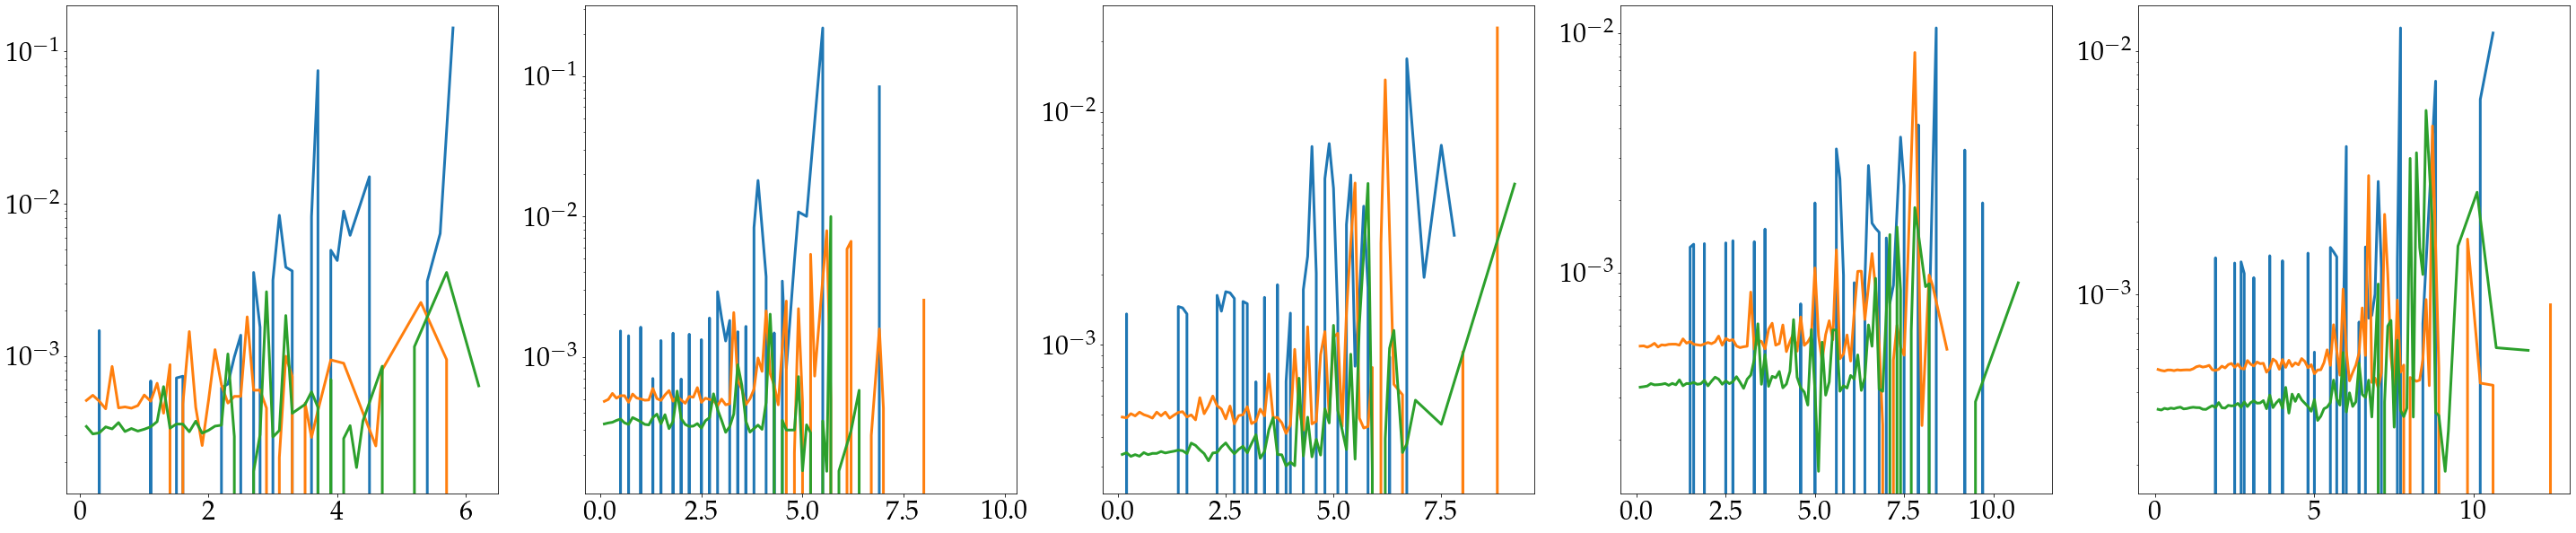

In [ ]:
fig,ax =plt.subplots(1,5,figsize=(50,10))
for i_b, beta in enumerate(beta_s):
    for i_mu, mu in enumerate(mu_s):
        chi_d = df[ np.logical_and(df['infection_rate']==beta, df['mutation_rate']==mu)][chi_columns].values[0]
        d_chi = df[ np.logical_and(df['infection_rate']==beta, df['mutation_rate']==mu)][d_columns].values[0]

        conditioned_dict= {}
        for d,chi in zip(d_chi,chi_d):
            if d in conditioned_dict:
                conditioned_dict[d].append(chi)
            else:
                if d>0:
                    conditioned_dict[d]=[chi]

        pos_chi_d=  chi_d[np.logical_and(d_chi>0,chi_d>0)]
        bmin , bmax=  np.min(pos_chi_d),np.max(pos_chi_d)
        avg_d = [np.median(conditioned_dict[d]) for d in sorted(conditioned_dict)]
        d_keys=  np.array(sorted(conditioned_dict.keys()))

        c,=ax[i_mu].plot(d_keys*p_alpha,avg_d)
        # ax.plot(d_keys*p_alpha,rho_d(d_keys,p_alpha)/(beta-1),color=c.get_color(),linestyle='--')
        ax[i_mu].set_yscale('log')

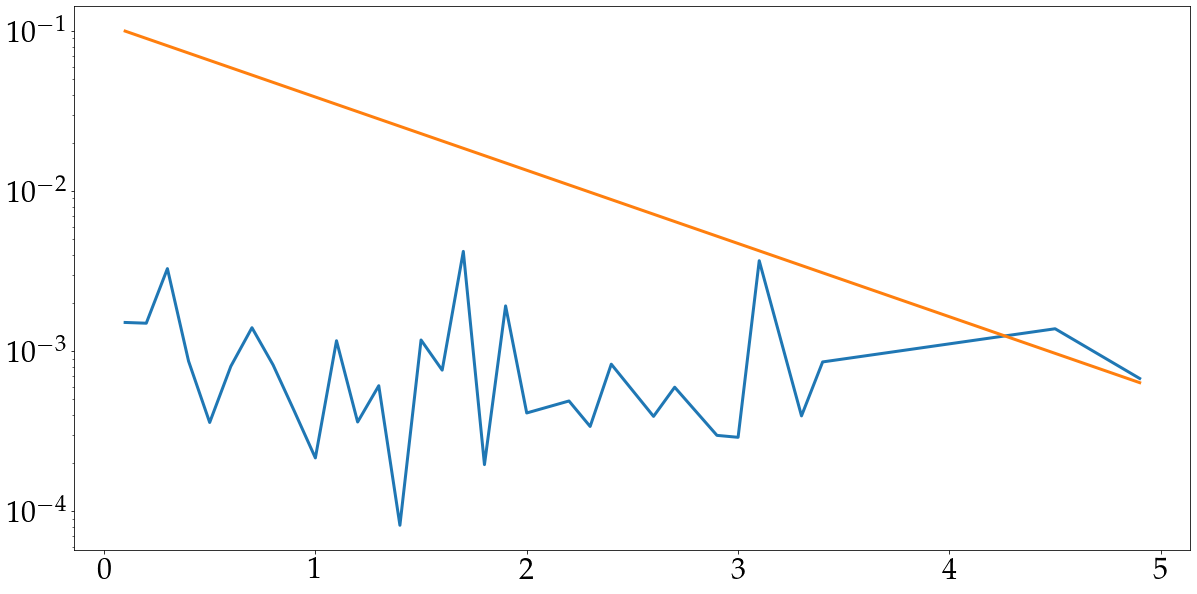

In [ ]:
d_keys=  np.array(sorted(conditioned_dict.keys()))

plt.plot(d_keys*p_alpha,avg_d)
plt.plot(d_keys*p_alpha,rho_d(d_keys,p_alpha))
plt.yscale('log')

In [ ]:
df[d_]

infection_rate  mutation_rate  d_0   d_1   d_2   d_3   d_4   d_5   d_6  \
0              1.5       0.000100  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1              1.5       0.000316  0.0   0.0  12.0   0.0   0.0   0.0   0.0   
2              1.5       0.001000  0.0   3.0   0.0   1.0   0.0   0.0   3.0   
3              1.5       0.003162  0.0   1.0   2.0   8.0   0.0   5.0   0.0   
4              1.5       0.010000  0.0   7.0  23.0   6.0   2.0  28.0  31.0   
5              2.5       0.000100  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6              2.5       0.000316  0.0   6.0   0.0   0.0   0.0   0.0  10.0   
7              2.5       0.001000  0.0  13.0  25.0   0.0  11.0   3.0   0.0   
8              2.5       0.003162  0.0   7.0   6.0   3.0   4.0   1.0   7.0   
9              2.5       0.010000  0.0  17.0  10.0   5.0  20.0   9.0  10.0   
10             3.5       0.000100  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
11             3.5       0.000316  0.0   0.0   7.0   7.0   0.0  26.0   0.0   
12             3.5       0.001000  0.0   2.0  11.0   0.0  31.0   8.0  26.0   
13             3.5       0.003162  0.0   3.0   3.0  13.0  12.0   2.0   1.0   
14             3.5       0.010000  0.0  12.0   3.0  23.0   4.0  12.0   4.0   

     d_7  ...  freq_110315  freq_110316  freq_110317  freq_110318  \
0    0.0  ...          NaN          NaN          NaN          NaN   
1    5.0  ...          NaN          NaN          NaN          NaN   
2    6.0  ...          NaN          NaN          NaN          NaN   
3    1.0  ...          NaN          NaN          NaN          NaN   
4    8.0  ...          NaN          NaN          NaN          NaN   
5    0.0  ...          NaN          NaN          NaN          NaN   
6    0.0  ...          NaN          NaN          NaN          NaN   
7   13.0  ...          NaN          NaN          NaN          NaN   
8    0.0  ...          NaN          NaN          NaN          NaN   
9    4.0  ...     0.000838     0.000419     0.001256     0.000838   
10   0.0  ...          NaN          NaN          NaN          NaN   
11  16.0  ...          NaN          NaN          NaN          NaN   
12   3.0  ...          NaN          NaN          NaN          NaN   
13  13.0  ...          NaN          NaN          NaN          NaN   
14   5.0  ...          NaN          NaN          NaN          NaN   

    freq_110319  freq_110320  freq_110321  freq_110322  freq_110323  \
0           NaN          NaN          NaN          NaN          NaN   
1           NaN          NaN          NaN          NaN          NaN   
2           NaN          NaN          NaN          NaN          NaN   
3           NaN          NaN          NaN          NaN          NaN   
4           NaN          NaN          NaN          NaN          NaN   
5           NaN          NaN          NaN          NaN          NaN   
6           NaN          NaN          NaN          NaN          NaN   
7           NaN          NaN          NaN          NaN          NaN   
8           NaN          NaN          NaN          NaN          NaN   
9      0.000419     0.000419     0.001256     0.000419     0.000419   
10          NaN          NaN          NaN          NaN          NaN   
11          NaN          NaN          NaN          NaN          NaN   
12          NaN          NaN          NaN          NaN          NaN   
13          NaN          NaN          NaN          NaN          NaN   
14          NaN          NaN          NaN          NaN          NaN   

    freq_110324  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
5           NaN  
6           NaN  
7           NaN  
8           NaN  
9      0.000419  
10          NaN  
11          NaN  
12          NaN  
13          NaN  
14          NaN  

[15 rows x 220652 columns]

In [ ]:
for dd in [df, df2, df3]:
            max_num_pairs = len(dd.columns[2:])//2

            d_columns= dd.columns[2:2+max_num_pairs]
            chi_columns= dd.columns[2+max_num_pairs:]
            chi_d = dd[ np.logical_and(dd['infection_rate']==beta, dd['mutation_rate']==mu)][chi_columns].values[0]
            d_chi = np.array(dd[ np.logical_and(dd['infection_rate']==beta, dd['mutation_rate']==mu)][d_columns].values[0])

            print(np.sum(d_chi==0))
            

5000
1000
250


In [ ]:
5000+1000+250

6250